<font color="#CC3D3D"><p>
# 트랜잭션 데이터로부터 feature를 생성한 후 학습용과 평가용 데이터로 나누기

- **Input**: 트랜잭션 데이터(`train_transactions.csv`, `test_transactions.csv`)
- **Output**: 위 데이터로부터 파생변수(feature)를 만든 후 모형 학습용(`X_train.csv`)과 평가용(`X_test.csv`) 데이터 생성

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

pd.set_option('max_columns', 20, 'max_rows', 20)

In [2]:
# 차트에서 한글 출력을 위한 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

<font color="blue"><p>
## Read Transactions

In [3]:
train = pd.read_csv('train_transactions.csv', encoding='cp949')
test = pd.read_csv('test_transactions.csv', encoding='cp949')
tr = pd.concat([train, test])

## Feature Generation

*새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.*

In [4]:
features = pd.DataFrame({'cust_id': tr.cust_id.unique()})

<br><font color='green'>
### Numeric Features

**[파생변수 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [5]:
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액
0           0   68282840    74   922741  11264000
1           1    2136000     3   712000   2136000
2           2    3197000     4   799250   1639000
3           3   16077620    44   365400   4935000
4           4   29050000     3  9683333  24000000
...       ...        ...   ...      ...       ...
5977     5977   82581500    14  5898679  23976000
5978     5978     480000     1   480000    480000
5979     5979  260003790    71  3662025  25750000
5980     5980   88991520    18  4943973  18120000
5981     5981     623700    10    62370    209000

[5982 rows x 5 columns]

In [6]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 5-7]** 구매상품종류(goods_id, gds_grp_nm, gds_grp_mclas_nm 각각)

In [7]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('구매상품종류1', lambda x: x.nunique())],
    'gds_grp_nm': [('구매상품종류2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('구매상품종류3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3
0           0   68282840    74   922741  11264000       35       28       17
1           1    2136000     3   712000   2136000        2        2        2
2           2    3197000     4   799250   1639000        1        2        2
3           3   16077620    44   365400   4935000       24       20       13
4           4   29050000     3  9683333  24000000        2        3        3
...       ...        ...   ...      ...       ...      ...      ...      ...
5977     5977   82581500    14  5898679  23976000        8        7        7
5978     5978     480000     1   480000    480000        1        1        1
5979     5979  260003790    71  3662025  25750000       38       28       19
5980     5980   88991520    18  4943973  18120000        9        7        5
5981     5981     623700    10    62370    209000        5        8        4

[5982 rows x 8 columns]

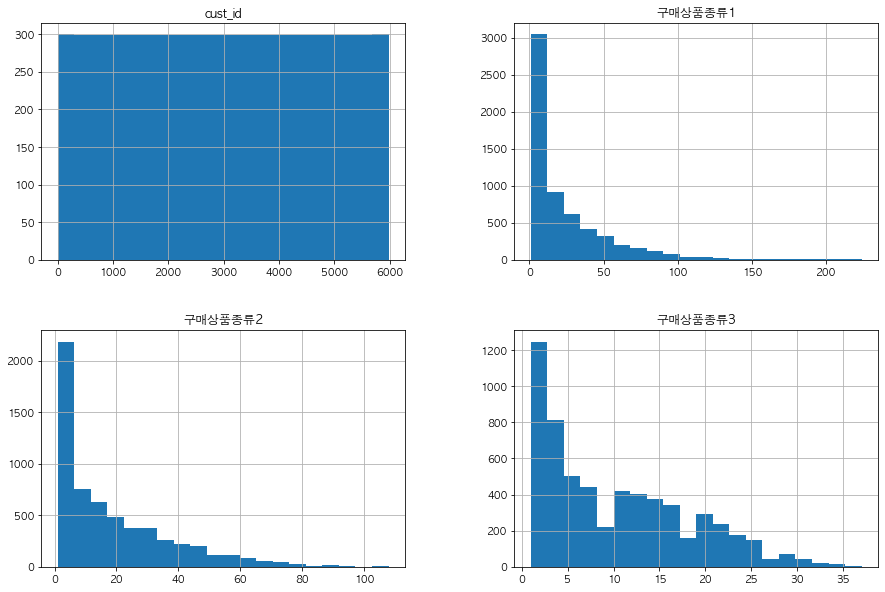

In [8]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 8-14]** 내점일수, 구매주기, 주말방문비율, 계절별 구매비율(Spring(3-5)/Summer(6-8)/Fall(9-11)/Winter(12-2))

In [9]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('내점일수',lambda x: x.str[:10].nunique()),
    ('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique())),
    ('주말방문비율', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4)),
    ('봄-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0           0   68282840    74   922741  11264000       35       28       17   
1           1    2136000     3   712000   2136000        2        2        2   
2           2    3197000     4   799250   1639000        1        2        2   
3           3   16077620    44   365400   4935000       24       20       13   
4           4   29050000     3  9683333  24000000        2        3        3   
...       ...        ...   ...      ...       ...      ...      ...      ...   
5977     5977   82581500    14  5898679  23976000        8        7        7   
5978     5978     480000     1   480000    480000        1        1        1   
5979     5979  260003790    71  3662025  25750000       38       28       19   
5980     5980   88991520    18  4943973  18120000        9        7        5   
5981     5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기    주말방문비율    봄-구매비율   여름-구매비율   가을-구매비율   겨울-구매비율  
0       19    17  0.527027  0.094595  0.391892  0.378378  0.135135  
1        2     1  0.000000  0.000000  0.000000  1.000000  0.000000  
2        2     1  0.000000  0.000000  0.000000  0.000000  1.000000  
3       18    16  0.318182  0.590909  0.159091  0.113636  0.136364  
4        2    85  0.000000  0.333333  0.000000  0.666667  0.000000  
...    ...   ...       ...       ...       ...       ...       ...  
5977     8    40  0.642857  0.071429  0.285714  0.285714  0.357143  
5978     1     0  0.000000  0.000000  0.000000  0.000000  1.000000  
5979    19    18  0.915493  0.154930  0.225352  0.154930  0.464789  
5980     5    60  0.444444  0.277778  0.166667  0.277778  0.277778  
5981     2    31  0.000000  0.100000  0.000000  0.000000  0.900000  

[5982 rows x 15 columns]

**[파생변수 15-16]** 환불금액, 환불건수

In [10]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([
    ('환불금액', lambda x: x.sum() * -1),
    ('환불건수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0           0   68282840    74   922741  11264000       35       28       17   
1           1    2136000     3   712000   2136000        2        2        2   
2           2    3197000     4   799250   1639000        1        2        2   
3           3   16077620    44   365400   4935000       24       20       13   
4           4   29050000     3  9683333  24000000        2        3        3   
...       ...        ...   ...      ...       ...      ...      ...      ...   
5977     5977   82581500    14  5898679  23976000        8        7        7   
5978     5978     480000     1   480000    480000        1        1        1   
5979     5979  260003790    71  3662025  25750000       38       28       19   
5980     5980   88991520    18  4943973  18120000        9        7        5   
5981     5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기    주말방문비율    봄-구매비율   여름-구매비율   가을-구매비율   겨울-구매비율       환불금액  \
0       19    17  0.527027  0.094595  0.391892  0.378378  0.135135  6860000.0   
1        2     1  0.000000  0.000000  0.000000  1.000000  0.000000   300000.0   
2        2     1  0.000000  0.000000  0.000000  0.000000  1.000000        NaN   
3       18    16  0.318182  0.590909  0.159091  0.113636  0.136364        NaN   
4        2    85  0.000000  0.333333  0.000000  0.666667  0.000000        NaN   
...    ...   ...       ...       ...       ...       ...       ...        ...   
5977     8    40  0.642857  0.071429  0.285714  0.285714  0.357143        NaN   
5978     1     0  0.000000  0.000000  0.000000  0.000000  1.000000        NaN   
5979    19    18  0.915493  0.154930  0.225352  0.154930  0.464789        NaN   
5980     5    60  0.444444  0.277778  0.166667  0.277778  0.277778        NaN   
5981     2    31  0.000000  0.100000  0.000000  0.000000  0.900000        NaN   

      환불건수  
0      3.0  
1      1.0  
2      NaN  
3      NaN  
4      NaN  
...    ...  
5977   NaN  
5978   NaN  
5979   NaN  
5980   NaN  
5981   NaN  

[5982 rows x 17 columns]

**[파생변수 17-18]** 내점 당 구매액, 구매건수

In [11]:
# 내점 당 구매액 = 총구매액 / 내점일수
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "내점당구매액"})
features = features.merge(f, how='left'); features
f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "내점당구매건수"})
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0           0   68282840    74   922741  11264000       35       28       17   
1           1    2136000     3   712000   2136000        2        2        2   
2           2    3197000     4   799250   1639000        1        2        2   
3           3   16077620    44   365400   4935000       24       20       13   
4           4   29050000     3  9683333  24000000        2        3        3   
...       ...        ...   ...      ...       ...      ...      ...      ...   
5977     5977   82581500    14  5898679  23976000        8        7        7   
5978     5978     480000     1   480000    480000        1        1        1   
5979     5979  260003790    71  3662025  25750000       38       28       19   
5980     5980   88991520    18  4943973  18120000        9        7        5   
5981     5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기    주말방문비율    봄-구매비율   여름-구매비율   가을-구매비율   겨울-구매비율       환불금액  \
0       19    17  0.527027  0.094595  0.391892  0.378378  0.135135  6860000.0   
1        2     1  0.000000  0.000000  0.000000  1.000000  0.000000   300000.0   
2        2     1  0.000000  0.000000  0.000000  0.000000  1.000000        NaN   
3       18    16  0.318182  0.590909  0.159091  0.113636  0.136364        NaN   
4        2    85  0.000000  0.333333  0.000000  0.666667  0.000000        NaN   
...    ...   ...       ...       ...       ...       ...       ...        ...   
5977     8    40  0.642857  0.071429  0.285714  0.285714  0.357143        NaN   
5978     1     0  0.000000  0.000000  0.000000  0.000000  1.000000        NaN   
5979    19    18  0.915493  0.154930  0.225352  0.154930  0.464789        NaN   
5980     5    60  0.444444  0.277778  0.166667  0.277778  0.277778        NaN   
5981     2    31  0.000000  0.100000  0.000000  0.000000  0.900000        NaN   

      환불건수        내점당구매액   내점당구매건수  
0      3.0  3.593834e+06  3.894737  
1      1.0  1.068000e+06  1.500000  
2      NaN  1.598500e+06  2.000000  
3      NaN  8.932011e+05  2.444444  
4      NaN  1.452500e+07  1.500000  
...    ...           ...       ...  
5977   NaN  1.032269e+07  1.750000  
5978   NaN  4.800000e+05  1.000000  
5979   NaN  1.368441e+07  3.736842  
5980   NaN  1.779830e+07  3.600000  
5981   NaN  3.118500e+05  5.000000  

[5982 rows x 19 columns]

**[파생변수 19-24]** 최근 3개월, 6개월, 12개월 구매금액 및 구매건수

In [12]:
# pd.to_datetime(), pd.offsets.MonthBegin(3)
for m in [3,6,12]:
    start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(m))
    f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'최근{m}개월_구매금액', np.sum), 
        (f'최근{m}개월_구매건수', np.size)
    ]).reset_index()
    display(f)
    features = features.merge(f, how='left'); features

cust_id  최근3개월_구매금액  최근3개월_구매건수
0           0    29084140          27
1           1     2136000           3
2           3      549620           4
3           4    27000000           2
4           7   140818200          36
...       ...         ...         ...
4199     5973     3212500           6
4200     5976    26358000          11
4201     5977    36256000           5
4202     5979   121061000          21
4203     5980     7528530           2

[4204 rows x 3 columns]

cust_id  최근6개월_구매금액  최근6개월_구매건수
0           0    42601240          61
1           1     2136000           3
2           3     1284060          11
3           4    27000000           2
4           6     2250000           2
...       ...         ...         ...
4759     5973     5712500           7
4760     5976   136971800          48
4761     5977    44158500           7
4762     5979   159653190          39
4763     5980    41243840          10

[4764 rows x 3 columns]

cust_id  최근12개월_구매금액  최근12개월_구매건수
0           0     68282840           74
1           1      2136000            3
2           2      3197000            4
3           3     16077620           44
4           4     29050000            3
...       ...          ...          ...
5977     5977     82581500           14
5978     5978       480000            1
5979     5979    260003790           71
5980     5980     88991520           18
5981     5981       623700           10

[5982 rows x 3 columns]

<br><font color='green'>
### Categorical Features

**[파생변수 25]** 주구매 상품: 가장 많이 구매한 상품(gds_grp_mclas_nm)

In [13]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features['주구매상품'].nunique()

43

In [14]:
# 범주형 속성 값의 빈도 출력
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='주구매상품', data=f, alpha=0.5)

<AxesSubplot:xlabel='count', ylabel='주구매상품'>

**[파생변수 26]** 주구매 지점

In [15]:
f = tr.groupby('cust_id')['store_nm'].agg([
    ('주구매지점', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0           0   68282840    74   922741  11264000       35       28       17   
1           1    2136000     3   712000   2136000        2        2        2   
2           2    3197000     4   799250   1639000        1        2        2   
3           3   16077620    44   365400   4935000       24       20       13   
4           4   29050000     3  9683333  24000000        2        3        3   
...       ...        ...   ...      ...       ...      ...      ...      ...   
5977     5977   82581500    14  5898679  23976000        8        7        7   
5978     5978     480000     1   480000    480000        1        1        1   
5979     5979  260003790    71  3662025  25750000       38       28       19   
5980     5980   88991520    18  4943973  18120000        9        7        5   
5981     5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...        내점당구매액   내점당구매건수   최근3개월_구매금액  최근3개월_구매건수  \
0       19    17  ...  3.593834e+06  3.894737   29084140.0        27.0   
1        2     1  ...  1.068000e+06  1.500000    2136000.0         3.0   
2        2     1  ...  1.598500e+06  2.000000          NaN         NaN   
3       18    16  ...  8.932011e+05  2.444444     549620.0         4.0   
4        2    85  ...  1.452500e+07  1.500000   27000000.0         2.0   
...    ...   ...  ...           ...       ...          ...         ...   
5977     8    40  ...  1.032269e+07  1.750000   36256000.0         5.0   
5978     1     0  ...  4.800000e+05  1.000000          NaN         NaN   
5979    19    18  ...  1.368441e+07  3.736842  121061000.0        21.0   
5980     5    60  ...  1.779830e+07  3.600000    7528530.0         2.0   
5981     2    31  ...  3.118500e+05  5.000000          NaN         NaN   

       최근6개월_구매금액  최근6개월_구매건수  최근12개월_구매금액  최근12개월_구매건수   주구매상품  주구매지점  
0      42601240.0        61.0     68282840           74      기타    강남점  
1       2136000.0         3.0      2136000            3     스포츠    잠실점  
2             NaN         NaN      3197000            4  남성 캐주얼    관악점  
3       1284060.0        11.0     16077620           44      기타    광주점  
4      27000000.0         2.0     29050000            3     화장품   본  점  
...           ...         ...          ...          ...     ...    ...  
5977   44158500.0         7.0     82581500           14      골프   부산본점  
5978          NaN         NaN       480000            1    섬유잡화    광주점  
5979  159653190.0        39.0    260003790           71  남성 캐주얼   본  점  
5980   41243840.0        10.0     88991520           18      육류   본  점  
5981          NaN         NaN       623700           10    가공식품   영등포점  

[5982 rows x 27 columns]

<br><font color='red'>
**[파생변수 27-35]** 추가로 새로운 파생변수를 제안하고 구현해야 함! 아래는 예시.
- 구매추세 패턴
- 가격선호도 (예: 고가상품구매율)
- 시즌 선호도
- 휴면(또는 이탈) 여부
- Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부
- 상품별 구매순서
- 주구매 요일 

### 구매 추세 기울기
#### 출처 : 12.ipynb

In [16]:
tr['tran_month'] = tr['tran_date'].apply(lambda x: x[5:7])

month = tr.groupby([tr['cust_id'],tr['tran_month']])['amount'].count().reset_index()
month.tran_month = month.tran_month.apply(lambda x: int(x))
df = pd.DataFrame(columns = ['cust_id', 'tran_month'])
for cust_id in range(0,5982):
    for tran_month in range(1,13):
        df = df.append(pd.DataFrame([[cust_id, tran_month]], columns = ['cust_id', 'tran_month']))
# groupby를 사용해본 결과 가지 않은 월의 경우 나타나지 않아 새로운 데이터프레임을 만들었다.
df = df.merge(month, how='left')
df = df.fillna(0)
# 결측치로 남은 남은 데이터를 0으로 만들어 가지 않은 달은 0이라는 값을 가지도록 했다.
df1 = pd.DataFrame(columns = ['cust_id', '기울기'])
for i in range(0,df.cust_id.nunique()):
    a = df.query('cust_id == @i').tran_month
    b = df.query('cust_id == @i').amount
    c = np.polyfit(a, b, 1)[0].round(2)
    df1 = df1.append(pd.DataFrame([[i, c]], columns = ['cust_id', '구매 추세 기울기']))
# 고객별 월 구매건수를 통해서 추세선을 찾고 기울기를 구하게 되었다.
features = features.merge(df1, how='left')

### 화장품구매주기
#### 출처 : 20.ipynb

In [17]:
f = tr.query('gds_grp_mclas_nm == "화장품"').groupby('cust_id')['tran_date'].agg([('화장품구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique()))]).reset_index()
features = features.merge(f, how='left');features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  최근3개월_구매건수   최근6개월_구매금액  최근6개월_구매건수  최근12개월_구매금액  \
0       19    17  ...        27.0   42601240.0        61.0     68282840   
1        2     1  ...         3.0    2136000.0         3.0      2136000   
2        2     1  ...         NaN          NaN         NaN      3197000   
3       18    16  ...         4.0    1284060.0        11.0     16077620   
4        2    85  ...         2.0   27000000.0         2.0     29050000   
...    ...   ...  ...         ...          ...         ...          ...   
5977     8    40  ...         5.0   44158500.0         7.0     82581500   
5978     1     0  ...         NaN          NaN         NaN       480000   
5979    19    18  ...        21.0  159653190.0        39.0    260003790   
5980     5    60  ...         2.0   41243840.0        10.0     88991520   
5981     2    31  ...         NaN          NaN         NaN       623700   

      최근12개월_구매건수   주구매상품  주구매지점  기울기  구매 추세 기울기  화장품구매주기  
0              74      기타    강남점  NaN       0.97     46.0  
1               3     스포츠    잠실점  NaN       0.07      NaN  
2               4  남성 캐주얼    관악점  NaN      -0.15      NaN  
3              44      기타    광주점  NaN      -0.38      NaN  
4               3     화장품   본  점  NaN       0.05      0.0  
...           ...     ...    ...  ...        ...      ...  
5977           14      골프   부산본점  NaN      -0.01      NaN  
5978            1    섬유잡화    광주점  NaN      -0.04      NaN  
5979           71  남성 캐주얼   본  점  NaN       0.05      NaN  
5980           18      육류   본  점  NaN      -0.01      NaN  
5981           10    가공식품   영등포점  NaN      -0.37      NaN  

[5982 rows x 30 columns]

### 식료품 구매액 비율
#### 출처 : 01.ipynb

In [18]:
food = ['축산가공', '육류', '수산품', '젓갈/반찬', '가공식품', '농산물', '차/커피', '주류'] # 식료품 대분류

# 총구매액
f = tr.groupby('cust_id')['amount'].agg([('총구매액', np.sum)]).reset_index()

# 식료품 구매액
food_amount = tr.query('gds_grp_mclas_nm == @food').groupby('cust_id')['amount'].agg([
    ('식료품구매액', np.sum)
]).reset_index()

f = pd.merge(f, food_amount, on = 'cust_id', how = 'left').fillna(0)


f['식료품구매액비율'] = f['식료품구매액'] / f['총구매액']
features = features.merge(f[['cust_id', '식료품구매액비율']], how = 'left')

### 평균 식료품 구매액 기반 고객 분류
#### 출처 : 01.ipynb

In [19]:
food = ['축산가공', '육류', '수산품', '젓갈/반찬', '가공식품', '농산물', '차/커피', '주류'] # 식료품 대분류

# 식료품 구매액
f_a = tr.query('gds_grp_mclas_nm == @food').groupby('cust_id')['amount'].agg([
    ('식료품구매액', np.sum)
]).reset_index()

# 식료품 구매건수
f_c = tr.query('gds_grp_mclas_nm == @food').groupby('cust_id')['amount'].agg([
    ('식료품구매건수', np.size)
]).reset_index()

# 평균 식료품 구매액
f = pd.merge(f_a, f_c, on = 'cust_id', how = 'left').fillna(0)
f['평균식료품구매액'] = f['식료품구매액'] / f['식료품구매건수']

# 평균 식료품 구매액 5구간으로 나눔
f['평균식료품구매액분위'] = pd.qcut(f['평균식료품구매액'], q=5, labels=range(1,6)).astype(int)
features = features.merge(f[['cust_id', '평균식료품구매액분위']], how = 'left')

### 고가 상품 구매율
#### 출처 : 01.ipynb

In [20]:
# goods_id에 따른 평균가 계산
price = tr.groupby('goods_id').mean().reset_index().drop(['cust_id'], axis = 1)

# column 명 변경
price.columns = ['goods_id', 'price']

# goods_id별 price에 대한 4분위수 계산 후 4분위를 고가상품으로 설정
price_4q = price['price'].quantile([.25,.5,.75])

# tr 데이터에 price columns 추가
tr = tr.merge(price, how = 'left')

f = tr.groupby('cust_id')['price'].agg([
    ('고가상품구매율', lambda x : (x > price_4q.iloc[2]).mean().round(2))
]).reset_index()

features = features.merge(f, how='left')

### 베스트 셀러 구매율
#### 출처 : 01.ipynb

In [21]:
best_sellers = ['농산물', '가공식품', '축산가공', '수산품', '화장품', '디자이너', '시티웨어', '일용잡화', '육류', '차/커피'] # 베스트 셀러 대분류

# 총구매건수
f = tr.groupby('cust_id')['amount'].agg([('구매건수', np.size)]).reset_index()

# 베스트 셀러 구매건수
b_s = tr.query('gds_grp_mclas_nm == @best_sellers').groupby('cust_id')['amount'].agg([
    ('베스트셀러구매건수', np.size)
]).reset_index()

f = pd.merge(f, b_s, on = 'cust_id', how = 'left').fillna(0)

f['베스트셀러구매비율'] = f['베스트셀러구매건수'] / f['구매건수']
features = features.merge(f[['cust_id', '베스트셀러구매비율']], how = 'left')

### 환불비율
#### 출처 : 01.ipynb

In [22]:
# 총구매건수
f = tr.groupby('cust_id')['amount'].agg([('구매건수', np.size)]).reset_index()

# 환불건수
g = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([('환불건수', np.size)]).reset_index()

f = f.merge(g, how = 'left').fillna(0)
f['환불비율'] = f['환불건수'] / f['구매건수']

features = features.merge(f[['cust_id', '환불비율']], how = 'left')

### 스타킹 구매 건수
#### 출처 : 01.ipynb

In [23]:
# 스타킹 구매건수
f = tr.query("gds_grp_nm == '스타킹(특정)'").groupby('cust_id')['amount'].agg([
    ('스타킹구매건수', np.size)
]).reset_index()

features = features.merge(f, how='left')

### RFM Score 기반 고객 분류
#### 출처 : 03.ipynb

In [24]:
r = tr.groupby('cust_id')['tran_date'].agg([
    ('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique()))]).reset_index()
f = tr.groupby('cust_id')['amount'].agg([ 
    ('구매건수', np.size)]).reset_index()
m = tr.groupby('cust_id')['amount'].agg([ 
    ('총구매액', np.sum)]).reset_index()
rfm = r.merge(f).merge(m)
r_labels = range(4, 0, -1) 
f_labels = range(1, 5)
m_labels = range(1, 5)

rfm['r'] = pd.qcut(rfm['구매주기'], q=4, labels=r_labels).astype(int)
rfm['f'] = pd.qcut(rfm['구매건수'], q=4, labels=f_labels).astype(int)
rfm['m'] = pd.qcut(rfm['총구매액'], q=4, labels=m_labels).astype(int)
rfm_s = [2, 2, 3]
rfm['rfm'] = rfm_s[0] * rfm['r'] + rfm_s[1] * rfm['f'] + rfm_s[2] * rfm['m']
seg_map = { 
    r'[1-2][1-2]': '수면고객',
    r'13': '이탈위험고객',
    r'14': '관심대상고객',
    r'23': '3등급고객',
    r'24': '2.5등급고객',
    r'[3-4]1': '신규고객',
    r'32': '3등급고객',
    r'42': '2.5등급고객',
    r'33': '2등급고객',
    r'43': '1등급고객',
    r'34': '1등급고객',
    r'44': 'vip고객'
}

rfm['고객등급'] = rfm['r'].map(str) + rfm['f'].map(str)
rfm['고객등급'] = rfm['고객등급'].replace(seg_map, regex=True)
rfm = rfm.drop("구매주기", axis=1)
rfm = rfm.drop("구매건수", axis=1)
rfm = rfm.drop("총구매액", axis=1)
rfm = rfm.drop("r", axis=1)
rfm = rfm.drop("f", axis=1)
rfm = rfm.drop("m", axis=1)
rfm = rfm.drop("rfm", axis=1)
features = features.merge(rfm, how='left');features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  기울기  구매 추세 기울기  화장품구매주기  식료품구매액비율  평균식료품구매액분위  고가상품구매율  \
0       19    17  ...  NaN       0.97     46.0  0.025218         2.0     0.24   
1        2     1  ...  NaN       0.07      NaN  0.000000         NaN     0.33   
2        2     1  ...  NaN      -0.15      NaN  0.000000         NaN     0.00   
3       18    16  ...  NaN      -0.38      NaN  0.237317         4.0     0.07   
4        2    85  ...  NaN       0.05      0.0  0.000000         NaN     1.00   
...    ...   ...  ...  ...        ...      ...       ...         ...      ...   
5977     8    40  ...  NaN      -0.01      NaN  0.000000         NaN     1.00   
5978     1     0  ...  NaN      -0.04      NaN  0.000000         NaN     0.00   
5979    19    18  ...  NaN       0.05      NaN  0.006470         5.0     0.48   
5980     5    60  ...  NaN      -0.01      NaN  0.582854         5.0     0.28   
5981     2    31  ...  NaN      -0.37      NaN  0.973304         2.0     0.00   

      베스트셀러구매비율      환불비율  스타킹구매건수   고객등급  
0      0.513514  0.040541      NaN  3등급고객  
1      0.000000  0.333333      NaN   신규고객  
2      0.000000  0.000000      NaN   신규고객  
3      0.545455  0.000000      2.0  3등급고객  
4      0.333333  0.000000      NaN   수면고객  
...         ...       ...      ...    ...  
5977   0.142857  0.000000      NaN   수면고객  
5978   0.000000  0.000000      NaN   신규고객  
5979   0.028169  0.000000      NaN  3등급고객  
5980   0.666667  0.000000      NaN   수면고객  
5981   0.800000  0.000000      NaN   수면고객  

[5982 rows x 37 columns]

### 고객의 평일방문비율
#### 출처 : 03.ipynb

In [25]:
t = tr.groupby('cust_id')['tran_date'].agg([
    ('평일방문비율', lambda x:np.mean(pd.to_datetime(x).dt.dayofweek<=4))
]).reset_index();t
features = features.merge(t, how='left');features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  구매 추세 기울기  화장품구매주기  식료품구매액비율  평균식료품구매액분위  고가상품구매율  \
0       19    17  ...       0.97     46.0  0.025218         2.0     0.24   
1        2     1  ...       0.07      NaN  0.000000         NaN     0.33   
2        2     1  ...      -0.15      NaN  0.000000         NaN     0.00   
3       18    16  ...      -0.38      NaN  0.237317         4.0     0.07   
4        2    85  ...       0.05      0.0  0.000000         NaN     1.00   
...    ...   ...  ...        ...      ...       ...         ...      ...   
5977     8    40  ...      -0.01      NaN  0.000000         NaN     1.00   
5978     1     0  ...      -0.04      NaN  0.000000         NaN     0.00   
5979    19    18  ...       0.05      NaN  0.006470         5.0     0.48   
5980     5    60  ...      -0.01      NaN  0.582854         5.0     0.28   
5981     2    31  ...      -0.37      NaN  0.973304         2.0     0.00   

      베스트셀러구매비율      환불비율  스타킹구매건수   고객등급    평일방문비율  
0      0.513514  0.040541      NaN  3등급고객  0.472973  
1      0.000000  0.333333      NaN   신규고객  1.000000  
2      0.000000  0.000000      NaN   신규고객  1.000000  
3      0.545455  0.000000      2.0  3등급고객  0.681818  
4      0.333333  0.000000      NaN   수면고객  1.000000  
...         ...       ...      ...    ...       ...  
5977   0.142857  0.000000      NaN   수면고객  0.357143  
5978   0.000000  0.000000      NaN   신규고객  1.000000  
5979   0.028169  0.000000      NaN  3등급고객  0.084507  
5980   0.666667  0.000000      NaN   수면고객  0.555556  
5981   0.800000  0.000000      NaN   수면고객  1.000000  

[5982 rows x 38 columns]

### 평균대비구매비중
#### 출처 : 03.ipynb

In [26]:
t = tr.groupby('cust_id')['amount'].sum() / tr.amount.mean()
t = t.astype(str).reset_index();t
t = t.rename(columns = {'amount' : '평균대비구매비중'});t
features = features.merge(t, how='left');features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  화장품구매주기  식료품구매액비율  평균식료품구매액분위  고가상품구매율  베스트셀러구매비율  \
0       19    17  ...     46.0  0.025218         2.0     0.24   0.513514   
1        2     1  ...      NaN  0.000000         NaN     0.33   0.000000   
2        2     1  ...      NaN  0.000000         NaN     0.00   0.000000   
3       18    16  ...      NaN  0.237317         4.0     0.07   0.545455   
4        2    85  ...      0.0  0.000000         NaN     1.00   0.333333   
...    ...   ...  ...      ...       ...         ...      ...        ...   
5977     8    40  ...      NaN  0.000000         NaN     1.00   0.142857   
5978     1     0  ...      NaN  0.000000         NaN     0.00   0.000000   
5979    19    18  ...      NaN  0.006470         5.0     0.48   0.028169   
5980     5    60  ...      NaN  0.582854         5.0     0.28   0.666667   
5981     2    31  ...      NaN  0.973304         2.0     0.00   0.800000   

          환불비율  스타킹구매건수   고객등급    평일방문비율            평균대비구매비중  
0     0.040541      NaN  3등급고객  0.472973   47.18187067132708  
1     0.333333      NaN   신규고객  1.000000  1.4759268324802344  
2     0.000000      NaN   신규고객  1.000000  2.2090534098498638  
3     0.000000      2.0  3등급고객  0.681818  11.109265337275687  
4     0.000000      NaN   수면고객  1.000000  20.072881312523787  
...        ...      ...    ...       ...                 ...  
5977  0.000000      NaN   수면고객  0.357143  57.061915597596666  
5978  0.000000      NaN   신규고객  1.000000  0.3316689511191538  
5979  0.000000      NaN  3등급고객  0.084507  179.65663399230152  
5980  0.000000      NaN   수면고객  0.555556  61.491091868539996  
5981  0.000000      NaN   수면고객  1.000000  0.4309623433604505  

[5982 rows x 39 columns]

### 주환불상품
#### 출처 : 03.ipynb

In [27]:
t = tr[tr.amount < 0].groupby('cust_id')['gds_grp_nm'].agg([
    ('주환불상품', lambda x: x.value_counts().index[0])
]).reset_index();t
features = features.merge(t, how='left');features['주환불상품'].nunique()

157

### '남성'이 포함된 상품 구매건수
#### 출처 : 03.ipynb

In [28]:
tr['남성'] = tr['gds_grp_mclas_nm'].str.contains('남성').astype(int)
t = tr[tr.남성 ==1].groupby('cust_id')['amount'].agg([
    ("남성포함상품구매건수" , np.size)
]).reset_index()
features = features.merge(t, how='left');features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  평균식료품구매액분위  고가상품구매율  베스트셀러구매비율      환불비율  스타킹구매건수  \
0       19    17  ...         2.0     0.24   0.513514  0.040541      NaN   
1        2     1  ...         NaN     0.33   0.000000  0.333333      NaN   
2        2     1  ...         NaN     0.00   0.000000  0.000000      NaN   
3       18    16  ...         4.0     0.07   0.545455  0.000000      2.0   
4        2    85  ...         NaN     1.00   0.333333  0.000000      NaN   
...    ...   ...  ...         ...      ...        ...       ...      ...   
5977     8    40  ...         NaN     1.00   0.142857  0.000000      NaN   
5978     1     0  ...         NaN     0.00   0.000000  0.000000      NaN   
5979    19    18  ...         5.0     0.48   0.028169  0.000000      NaN   
5980     5    60  ...         5.0     0.28   0.666667  0.000000      NaN   
5981     2    31  ...         2.0     0.00   0.800000  0.000000      NaN   

       고객등급    평일방문비율            평균대비구매비중   주환불상품  남성포함상품구매건수  
0     3등급고객  0.472973   47.18187067132708  디자이너부틱         1.0  
1      신규고객  1.000000  1.4759268324802344    아웃도아         NaN  
2      신규고객  1.000000  2.2090534098498638     NaN         2.0  
3     3등급고객  0.681818  11.109265337275687     NaN         NaN  
4      수면고객  1.000000  20.072881312523787     NaN         NaN  
...     ...       ...                 ...     ...         ...  
5977   수면고객  0.357143  57.061915597596666     NaN         NaN  
5978   신규고객  1.000000  0.3316689511191538     NaN         NaN  
5979  3등급고객  0.084507  179.65663399230152     NaN        14.0  
5980   수면고객  0.555556  61.491091868539996     NaN         NaN  
5981   수면고객  1.000000  0.4309623433604505     NaN         NaN  

[5982 rows x 41 columns]

### 여성관련 키워드가 포함된 상품 구매건수
#### 출처 : 03.ipynb

In [29]:
tr['여성'] = tr['gds_grp_mclas_nm'].str.startswith(('여','화장품','주방','란제리')).astype(int)
t = tr[tr.여성 ==1].groupby('cust_id')['amount'].agg([
    ("여성키워드상품구매건수" , np.size)
]).reset_index()
features = features.merge(t, how='left');features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  고가상품구매율  베스트셀러구매비율      환불비율  스타킹구매건수   고객등급    평일방문비율  \
0       19    17  ...     0.24   0.513514  0.040541      NaN  3등급고객  0.472973   
1        2     1  ...     0.33   0.000000  0.333333      NaN   신규고객  1.000000   
2        2     1  ...     0.00   0.000000  0.000000      NaN   신규고객  1.000000   
3       18    16  ...     0.07   0.545455  0.000000      2.0  3등급고객  0.681818   
4        2    85  ...     1.00   0.333333  0.000000      NaN   수면고객  1.000000   
...    ...   ...  ...      ...        ...       ...      ...    ...       ...   
5977     8    40  ...     1.00   0.142857  0.000000      NaN   수면고객  0.357143   
5978     1     0  ...     0.00   0.000000  0.000000      NaN   신규고객  1.000000   
5979    19    18  ...     0.48   0.028169  0.000000      NaN  3등급고객  0.084507   
5980     5    60  ...     0.28   0.666667  0.000000      NaN   수면고객  0.555556   
5981     2    31  ...     0.00   0.800000  0.000000      NaN   수면고객  1.000000   

                평균대비구매비중   주환불상품  남성포함상품구매건수  여성키워드상품구매건수  
0      47.18187067132708  디자이너부틱         1.0          9.0  
1     1.4759268324802344    아웃도아         NaN          NaN  
2     2.2090534098498638     NaN         2.0          NaN  
3     11.109265337275687     NaN         NaN          NaN  
4     20.072881312523787     NaN         NaN          1.0  
...                  ...     ...         ...          ...  
5977  57.061915597596666     NaN         NaN          NaN  
5978  0.3316689511191538     NaN         NaN          NaN  
5979  179.65663399230152     NaN        14.0          2.0  
5980  61.491091868539996     NaN         NaN          NaN  
5981  0.4309623433604505     NaN         NaN          NaN  

[5982 rows x 42 columns]

### 다양한 매장 방문
#### 출처 : 12.ipynb

In [30]:
f = tr.groupby('cust_id')['store_nm'].agg([('다양한 매장 방문','nunique')]).reset_index() # 다양한 매장 방문
features = features.merge(f, how='left')

### 가격 선호도
#### 출처 : 05.ipynb

In [31]:
# 고객별 구매 금액의 평균으로 가격 선호도 추출
# 선호도의 숫자(1~5)가 높을수록 고가형 제품을 선호

def grade(x):
    if x <= 500000:
        return 1
    elif x <= 2000000:
        return 2
    elif x <= 5000000:
        return 3
    elif x <= 10000000:
        return 4
    elif x <= 50000000:
        return 5

    
f = tr.groupby('cust_id')['amount'].agg([
    ('가격선호도', lambda x: grade(np.mean(x)))
]).reset_index()
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...      환불비율  스타킹구매건수   고객등급    평일방문비율            평균대비구매비중  \
0       19    17  ...  0.040541      NaN  3등급고객  0.472973   47.18187067132708   
1        2     1  ...  0.333333      NaN   신규고객  1.000000  1.4759268324802344   
2        2     1  ...  0.000000      NaN   신규고객  1.000000  2.2090534098498638   
3       18    16  ...  0.000000      2.0  3등급고객  0.681818  11.109265337275687   
4        2    85  ...  0.000000      NaN   수면고객  1.000000  20.072881312523787   
...    ...   ...  ...       ...      ...    ...       ...                 ...   
5977     8    40  ...  0.000000      NaN   수면고객  0.357143  57.061915597596666   
5978     1     0  ...  0.000000      NaN   신규고객  1.000000  0.3316689511191538   
5979    19    18  ...  0.000000      NaN  3등급고객  0.084507  179.65663399230152   
5980     5    60  ...  0.000000      NaN   수면고객  0.555556  61.491091868539996   
5981     2    31  ...  0.000000      NaN   수면고객  1.000000  0.4309623433604505   

       주환불상품  남성포함상품구매건수  여성키워드상품구매건수  다양한 매장 방문  가격선호도  
0     디자이너부틱         1.0          9.0          2    2.0  
1       아웃도아         NaN          NaN          1    2.0  
2        NaN         2.0          NaN          1    2.0  
3        NaN         NaN          NaN          1    1.0  
4        NaN         NaN          1.0          1    4.0  
...      ...         ...          ...        ...    ...  
5977     NaN         NaN          NaN          2    4.0  
5978     NaN         NaN          NaN          1    1.0  
5979     NaN        14.0          2.0          1    3.0  
5980     NaN         NaN          NaN          1    3.0  
5981     NaN         NaN          NaN          1    1.0  

[5982 rows x 44 columns]

### 라이프스타일 선호도
#### 출처 : 05.ipynb

In [32]:
# 고객별 구매 금액의 평균과 구매 건수에 따른 라이프 스타일 추출

def lifeStyle(x):
    if x in ['농산물', '가공식품', '축산가공', '수산품', '육류', '차/커피', '젓갈/반찬', '건강식품', '주류']:
        return '식품'
    elif x in ['주방가전', '대형가전', '가구', '소형가전', '통신/컴퓨터', '전자/전기']:
        return '가전'
    elif x in ['일용잡화', '주방용품', '생활잡화', '식기', '침구/수예', '문구/팬시']:
        return '생활용품'
    elif x in ['골프', '스포츠', '악기']:
        return '예체능'
    elif x in ['액세서리', '준보석/시계', '디자이너', '명품', '보석']:
        return '명품'
    elif x in ['트래디셔널', '시티웨어', '섬유잡화', '캐주얼', '구두', '기타의류', '교복', '커리어']:
        return '의류'
    elif x in ['남성 캐주얼', '셔츠', '남성정장', '남성 트랜디']:
        return '남성의류'
    elif x in ['모피/피혁', '피혁잡화', '웨딩', '멀티(아울렛)', '란제리/내의']:
        return '여성의류'
    elif x in ['아동']:
        return '아동용품'
    elif x in ['화장품']:
        return '화장품'
    elif x in ['기타']:
        return '기타'
    
tr["lifeStyle"]=tr['gds_grp_mclas_nm'].apply(lifeStyle)

f = pd.pivot_table(tr, index='cust_id', columns='lifeStyle', values='amount', aggfunc=np.mean, fill_value=0).reset_index()
a = f.iloc[:,1:12] 
a['라이프 스타일(평균)'] = a.idxmax(axis=1)
f = pd.concat([f, a], axis=1)['라이프 스타일(평균)'].reset_index(name = '라이프 스타일(평균)').rename(columns = {'index' : 'cust_id'})
features = features.merge(f, how='left'); features

f = pd.pivot_table(tr, index='cust_id', columns='lifeStyle', values='amount', aggfunc=np.size, fill_value=0).reset_index()
a = f.iloc[:,1:12] 
a['라이프 스타일(건수)'] = a.idxmax(axis=1)
f = pd.concat([f, a], axis=1)['라이프 스타일(건수)'].reset_index(name = '라이프 스타일(건수)').rename(columns = {'index' : 'cust_id'})
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...   고객등급    평일방문비율            평균대비구매비중   주환불상품  \
0       19    17  ...  3등급고객  0.472973   47.18187067132708  디자이너부틱   
1        2     1  ...   신규고객  1.000000  1.4759268324802344    아웃도아   
2        2     1  ...   신규고객  1.000000  2.2090534098498638     NaN   
3       18    16  ...  3등급고객  0.681818  11.109265337275687     NaN   
4        2    85  ...   수면고객  1.000000  20.072881312523787     NaN   
...    ...   ...  ...    ...       ...                 ...     ...   
5977     8    40  ...   수면고객  0.357143  57.061915597596666     NaN   
5978     1     0  ...   신규고객  1.000000  0.3316689511191538     NaN   
5979    19    18  ...  3등급고객  0.084507  179.65663399230152     NaN   
5980     5    60  ...   수면고객  0.555556  61.491091868539996     NaN   
5981     2    31  ...   수면고객  1.000000  0.4309623433604505     NaN   

      남성포함상품구매건수  여성키워드상품구매건수  다양한 매장 방문  가격선호도  라이프 스타일(평균)  라이프 스타일(건수)  
0            1.0          9.0          2    2.0          화장품           식품  
1            NaN          NaN          1    2.0           의류          예체능  
2            2.0          NaN          1    2.0         남성의류           기타  
3            NaN          NaN          1    1.0         생활용품           식품  
4            NaN          1.0          1    4.0           명품           기타  
...          ...          ...        ...    ...          ...          ...  
5977         NaN          NaN          2    4.0           식품          예체능  
5978         NaN          NaN          1    1.0           의류           의류  
5979        14.0          2.0          1    3.0         남성의류           의류  
5980         NaN          NaN          1    3.0         아동용품           식품  
5981         NaN          NaN          1    1.0           식품           식품  

[5982 rows x 46 columns]

### 주구매 요일
#### 출처 : 05.ipynb

In [33]:
# 고객별 주로 방문한 요일 추출

tr['요일'] = tr['tran_date'].agg(lambda x: ('월', '화', '수', '목', '금', '토', '일')[pd.to_datetime(x).weekday()])

f = tr.groupby('cust_id')['요일'].agg([('주구매 요일', lambda x: x.value_counts().index[0])]).reset_index()
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...    평일방문비율            평균대비구매비중   주환불상품  남성포함상품구매건수  \
0       19    17  ...  0.472973   47.18187067132708  디자이너부틱         1.0   
1        2     1  ...  1.000000  1.4759268324802344    아웃도아         NaN   
2        2     1  ...  1.000000  2.2090534098498638     NaN         2.0   
3       18    16  ...  0.681818  11.109265337275687     NaN         NaN   
4        2    85  ...  1.000000  20.072881312523787     NaN         NaN   
...    ...   ...  ...       ...                 ...     ...         ...   
5977     8    40  ...  0.357143  57.061915597596666     NaN         NaN   
5978     1     0  ...  1.000000  0.3316689511191538     NaN         NaN   
5979    19    18  ...  0.084507  179.65663399230152     NaN        14.0   
5980     5    60  ...  0.555556  61.491091868539996     NaN         NaN   
5981     2    31  ...  1.000000  0.4309623433604505     NaN         NaN   

      여성키워드상품구매건수  다양한 매장 방문  가격선호도  라이프 스타일(평균)  라이프 스타일(건수)  주구매 요일  
0             9.0          2    2.0          화장품           식품       토  
1             NaN          1    2.0           의류          예체능       목  
2             NaN          1    2.0         남성의류           기타       월  
3             NaN          1    1.0         생활용품           식품       화  
4             1.0          1    4.0           명품           기타       수  
...           ...        ...    ...          ...          ...     ...  
5977          NaN          2    4.0           식품          예체능       토  
5978          NaN          1    1.0           의류           의류       월  
5979          2.0          1    3.0         남성의류           의류       일  
5980          NaN          1    3.0         아동용품           식품       토  
5981          NaN          1    1.0           식품           식품       금  

[5982 rows x 47 columns]

### 선호방문계절, 선호방문월
#### 출처 : 06.ipynb

In [34]:
tr['month'] = tr['tran_date'].agg(lambda x: pd.to_datetime(x).month)
tr['season'] = tr['month'].agg(lambda x: 'spring' if x in [3,4,5] else 'summer' if x in [6,7,8]
                              else 'fall' if x in [9,10,11] else 'fall')
f = tr.groupby('cust_id')['season'].agg([
    ('선호방문계절', lambda x: x.value_counts().index[0])
])
f['선호방문월'] = tr.groupby('cust_id')['month'].apply(lambda x: x.value_counts().index[0])
f
features = features.merge(f, on = 'cust_id', how = 'left') ; features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...   주환불상품  남성포함상품구매건수  여성키워드상품구매건수  다양한 매장 방문  가격선호도  \
0       19    17  ...  디자이너부틱         1.0          9.0          2    2.0   
1        2     1  ...    아웃도아         NaN          NaN          1    2.0   
2        2     1  ...     NaN         2.0          NaN          1    2.0   
3       18    16  ...     NaN         NaN          NaN          1    1.0   
4        2    85  ...     NaN         NaN          1.0          1    4.0   
...    ...   ...  ...     ...         ...          ...        ...    ...   
5977     8    40  ...     NaN         NaN          NaN          2    4.0   
5978     1     0  ...     NaN         NaN          NaN          1    1.0   
5979    19    18  ...     NaN        14.0          2.0          1    3.0   
5980     5    60  ...     NaN         NaN          NaN          1    3.0   
5981     2    31  ...     NaN         NaN          NaN          1    1.0   

      라이프 스타일(평균)  라이프 스타일(건수)  주구매 요일  선호방문계절  선호방문월  
0             화장품           식품       토    fall     10  
1              의류          예체능       목    fall     10  
2            남성의류           기타       월    fall      1  
3            생활용품           식품       화  spring      3  
4              명품           기타       수    fall     11  
...           ...          ...     ...     ...    ...  
5977           식품          예체능       토    fall      1  
5978           의류           의류       월    fall      1  
5979         남성의류           의류       일    fall      1  
5980         아동용품           식품       토    fall      9  
5981           식품           식품       금    fall      1  

[5982 rows x 49 columns]

### 행사상품구매수
#### 출처 : 06.ipynb

In [35]:
f = tr[tr.gds_grp_mclas_nm.str.contains('행사') | tr.gds_grp_nm.str.contains('행사')]
f = f.groupby('cust_id')['amount'].agg([
    ('행사상품구매수','count')
])
features = features.merge(f, on = 'cust_id', how = 'left')

### 저가상품구매비율
#### 출처 : 07.ipynb

In [36]:
price_4q = tr.groupby('goods_id')['amount'].mean().quantile([.25,.5,.75])
price_4q
f = (tr.groupby('cust_id')['amount']
     .agg([('저가상품구매율', lambda x: (x < price_4q.iloc[0]).mean().round(2))])
     .reset_index())
f
features = features.merge(f, how='left')

### 요일 간 구매건수 편차
#### 출처 : 07.ipynb

In [37]:
tr.tran_date = tr.tran_date.astype(str).astype('datetime64') 
#요일 컬럼 추가
tr['weekday_name'] = tr['tran_date'].dt.day_name()
tr['weekday'] = tr['tran_date'].dt.weekday

In [38]:
f = pd.pivot_table(tr, index = 'cust_id', columns = 'weekday', values = 'amount', aggfunc = ['count'])
f1 = f.transpose()/f.transpose().sum()
f = f1.transpose()
f = f.fillna(0)
f2 = np.apply_along_axis(lambda x: np.max(x) - np.min(x), 1, f)
features = pd.concat((features, pd.DataFrame(f2)), axis = 1)
features = features.rename({0:'요일 간 구매건수 편차'}, axis = 'columns');features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  다양한 매장 방문  가격선호도  라이프 스타일(평균)  라이프 스타일(건수)  주구매 요일  \
0       19    17  ...          2    2.0          화장품           식품       토   
1        2     1  ...          1    2.0           의류          예체능       목   
2        2     1  ...          1    2.0         남성의류           기타       월   
3       18    16  ...          1    1.0         생활용품           식품       화   
4        2    85  ...          1    4.0           명품           기타       수   
...    ...   ...  ...        ...    ...          ...          ...     ...   
5977     8    40  ...          2    4.0           식품          예체능       토   
5978     1     0  ...          1    1.0           의류           의류       월   
5979    19    18  ...          1    3.0         남성의류           의류       일   
5980     5    60  ...          1    3.0         아동용품           식품       토   
5981     2    31  ...          1    1.0           식품           식품       금   

      선호방문계절  선호방문월  행사상품구매수  저가상품구매율  요일 간 구매건수 편차  
0       fall     10      5.0     0.43      0.337838  
1       fall     10      NaN     0.33      0.666667  
2       fall      1      NaN     0.50      0.500000  
3     spring      3      NaN     0.50      0.181818  
4       fall     11      NaN     0.00      0.666667  
...      ...    ...      ...      ...           ...  
5977    fall      1      NaN     0.00      0.500000  
5978    fall      1      NaN     0.00      1.000000  
5979    fall      1      NaN     0.07      0.915493  
5980    fall      9      NaN     0.00      0.444444  
5981    fall      1      NaN     0.70      1.000000  

[5982 rows x 52 columns]

### 구매 물품 종류 수
#### 출처 : 09.ipynb

In [39]:
f = tr.groupby('cust_id')['goods_id'].agg([
    ('구매물품종류수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  가격선호도  라이프 스타일(평균)  라이프 스타일(건수)  주구매 요일  선호방문계절  선호방문월  \
0       19    17  ...    2.0          화장품           식품       토    fall     10   
1        2     1  ...    2.0           의류          예체능       목    fall     10   
2        2     1  ...    2.0         남성의류           기타       월    fall      1   
3       18    16  ...    1.0         생활용품           식품       화  spring      3   
4        2    85  ...    4.0           명품           기타       수    fall     11   
...    ...   ...  ...    ...          ...          ...     ...     ...    ...   
5977     8    40  ...    4.0           식품          예체능       토    fall      1   
5978     1     0  ...    1.0           의류           의류       월    fall      1   
5979    19    18  ...    3.0         남성의류           의류       일    fall      1   
5980     5    60  ...    3.0         아동용품           식품       토    fall      9   
5981     2    31  ...    1.0           식품           식품       금    fall      1   

      행사상품구매수  저가상품구매율  요일 간 구매건수 편차  구매물품종류수  
0         5.0     0.43      0.337838       74  
1         NaN     0.33      0.666667        3  
2         NaN     0.50      0.500000        4  
3         NaN     0.50      0.181818       44  
4         NaN     0.00      0.666667        3  
...       ...      ...           ...      ...  
5977      NaN     0.00      0.500000       14  
5978      NaN     0.00      1.000000        1  
5979      NaN     0.07      0.915493       71  
5980      NaN     0.00      0.444444       18  
5981      NaN     0.70      1.000000       10  

[5982 rows x 53 columns]

### 충동지수
#### 출처 : 10.ipynb

In [40]:
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum)
]).reset_index()
features = features.merge(f, how='left');
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "내점당구매액"})
features = features.merge(f, how='left');
features["충동지수"] = features["내점당구매액"]/features["총구매액"]
features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  라이프 스타일(평균)  라이프 스타일(건수)  주구매 요일  선호방문계절  선호방문월  \
0       19    17  ...          화장품           식품       토    fall     10   
1        2     1  ...           의류          예체능       목    fall     10   
2        2     1  ...         남성의류           기타       월    fall      1   
3       18    16  ...         생활용품           식품       화  spring      3   
4        2    85  ...           명품           기타       수    fall     11   
...    ...   ...  ...          ...          ...     ...     ...    ...   
5977     8    40  ...           식품          예체능       토    fall      1   
5978     1     0  ...           의류           의류       월    fall      1   
5979    19    18  ...         남성의류           의류       일    fall      1   
5980     5    60  ...         아동용품           식품       토    fall      9   
5981     2    31  ...           식품           식품       금    fall      1   

      행사상품구매수  저가상품구매율  요일 간 구매건수 편차  구매물품종류수      충동지수  
0         5.0     0.43      0.337838       74  0.052632  
1         NaN     0.33      0.666667        3  0.500000  
2         NaN     0.50      0.500000        4  0.500000  
3         NaN     0.50      0.181818       44  0.055556  
4         NaN     0.00      0.666667        3  0.500000  
...       ...      ...           ...      ...       ...  
5977      NaN     0.00      0.500000       14  0.125000  
5978      NaN     0.00      1.000000        1  1.000000  
5979      NaN     0.07      0.915493       71  0.052632  
5980      NaN     0.00      0.444444       18  0.200000  
5981      NaN     0.70      1.000000       10  0.500000  

[5982 rows x 54 columns]

### 가장 비싸게 산 품목
#### 출처 : 10.ipynb

In [41]:
f = tr.groupby('cust_id')['amount'].agg([
    ('최대구매액', np.max)
]).reset_index()
features = features.merge(f, how='left');

features['가장 비싸게 산 품목'] = 0
for i in range(len(tr)):
    if tr.iloc[i,6] == features.iloc[tr.iloc[i,0],8]:
        features['가장 비싸게 산 품목'][tr.iloc[i,0]] = tr.iloc[i,4]
features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  라이프 스타일(건수)  주구매 요일  선호방문계절  선호방문월  행사상품구매수  저가상품구매율  \
0       19    17  ...           식품       토    fall     10      5.0     0.43   
1        2     1  ...          예체능       목    fall     10      NaN     0.33   
2        2     1  ...           기타       월    fall      1      NaN     0.50   
3       18    16  ...           식품       화  spring      3      NaN     0.50   
4        2    85  ...           기타       수    fall     11      NaN     0.00   
...    ...   ...  ...          ...     ...     ...    ...      ...      ...   
5977     8    40  ...          예체능       토    fall      1      NaN     0.00   
5978     1     0  ...           의류       월    fall      1      NaN     0.00   
5979    19    18  ...           의류       일    fall      1      NaN     0.07   
5980     5    60  ...           식품       토    fall      9      NaN     0.00   
5981     2    31  ...           식품       금    fall      1      NaN     0.70   

      요일 간 구매건수 편차  구매물품종류수      충동지수  가장 비싸게 산 품목  
0         0.337838       74  0.052632            0  
1         0.666667        3  0.500000            0  
2         0.500000        4  0.500000            0  
3         0.181818       44  0.055556            0  
4         0.666667        3  0.500000            0  
...            ...      ...       ...          ...  
5977      0.500000       14  0.125000            0  
5978      1.000000        1  1.000000            0  
5979      0.915493       71  0.052632            0  
5980      0.444444       18  0.200000            0  
5981      1.000000       10  0.500000            0  

[5982 rows x 55 columns]

### vip지수
#### 출처 : 10.ipynb

In [42]:
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum)
]).reset_index()
features = features.merge(f, how='left');
features["vip지수"] = features["총구매액"]/18000000
features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  주구매 요일  선호방문계절  선호방문월  행사상품구매수  저가상품구매율  요일 간 구매건수 편차  \
0       19    17  ...       토    fall     10      5.0     0.43      0.337838   
1        2     1  ...       목    fall     10      NaN     0.33      0.666667   
2        2     1  ...       월    fall      1      NaN     0.50      0.500000   
3       18    16  ...       화  spring      3      NaN     0.50      0.181818   
4        2    85  ...       수    fall     11      NaN     0.00      0.666667   
...    ...   ...  ...     ...     ...    ...      ...      ...           ...   
5977     8    40  ...       토    fall      1      NaN     0.00      0.500000   
5978     1     0  ...       월    fall      1      NaN     0.00      1.000000   
5979    19    18  ...       일    fall      1      NaN     0.07      0.915493   
5980     5    60  ...       토    fall      9      NaN     0.00      0.444444   
5981     2    31  ...       금    fall      1      NaN     0.70      1.000000   

      구매물품종류수      충동지수  가장 비싸게 산 품목      vip지수  
0          74  0.052632            0   3.793491  
1           3  0.500000            0   0.118667  
2           4  0.500000            0   0.177611  
3          44  0.055556            0   0.893201  
4           3  0.500000            0   1.613889  
...       ...       ...          ...        ...  
5977       14  0.125000            0   4.587861  
5978        1  1.000000            0   0.026667  
5979       71  0.052632            0  14.444655  
5980       18  0.200000            0   4.943973  
5981       10  0.500000            0   0.034650  

[5982 rows x 56 columns]

### 주중방문건수
#### 출처 : 11.ipynb

In [43]:
f= tr.groupby('cust_id')['tran_date'].agg([
    ('주중방문건수', lambda x: np.sum(pd.to_datetime(x).dt.dayofweek<=4))

]).reset_index()
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  선호방문계절  선호방문월  행사상품구매수  저가상품구매율  요일 간 구매건수 편차  구매물품종류수  \
0       19    17  ...    fall     10      5.0     0.43      0.337838       74   
1        2     1  ...    fall     10      NaN     0.33      0.666667        3   
2        2     1  ...    fall      1      NaN     0.50      0.500000        4   
3       18    16  ...  spring      3      NaN     0.50      0.181818       44   
4        2    85  ...    fall     11      NaN     0.00      0.666667        3   
...    ...   ...  ...     ...    ...      ...      ...           ...      ...   
5977     8    40  ...    fall      1      NaN     0.00      0.500000       14   
5978     1     0  ...    fall      1      NaN     0.00      1.000000        1   
5979    19    18  ...    fall      1      NaN     0.07      0.915493       71   
5980     5    60  ...    fall      9      NaN     0.00      0.444444       18   
5981     2    31  ...    fall      1      NaN     0.70      1.000000       10   

          충동지수  가장 비싸게 산 품목      vip지수  주중방문건수  
0     0.052632            0   3.793491      35  
1     0.500000            0   0.118667       3  
2     0.500000            0   0.177611       4  
3     0.055556            0   0.893201      30  
4     0.500000            0   1.613889       3  
...        ...          ...        ...     ...  
5977  0.125000            0   4.587861       5  
5978  1.000000            0   0.026667       1  
5979  0.052632            0  14.444655       6  
5980  0.200000            0   4.943973      10  
5981  0.500000            0   0.034650      10  

[5982 rows x 57 columns]

### 남성용품구매건수, 여성용품구매건수
#### 출처 : 12.ipynb

In [44]:
# 새로운 상품군 만들기
# 이름 그대로 남성, 여성이 붙은 상품이 있는 것을 발견했고 이를 포함해서 주 구매층이 남성, 여성인 제품들을 묶어 새로운 상품군을 만들었다.
# 이성에게 선물을 해주는 경우가 존재하지만 소수일 것이라 생각했다.

man_goods = ['N.B정장','N/B골프의류','주류','직수입 골프의류','스포츠화',
             'L/C골프의류','L/C정장','단기행사(골프)','스포츠의류','레포츠',
             '안주류','시계','넥타이(특정)','고정행사(골프)','등산화','골프용품',
             '명품남성','셔츠고정행사','셔츠단기행사','명품시계기타',
             '기타(가발,포장,담배,끽연구,사진,수선)','정상스포츠','단기행사(레져)',
             '고정행사(레져)','시티정장바지','넥타이핀','직수입정장','맞춤셔츠',
             '셔츠 직매입(PB)','IT 게임기','명품시계직매입','남성잡화멀티',
             '정장점행사','NB 남화','남성시티 직매입']

woman_goods = ['디자이너부틱','어덜트','란제리행사','뷰티상품','스타킹(특정)','보석',
               '크리스탈','란제리','디자이너','색조 화장품','NB 여화','일반핸드백',
               '직수입핸드백','숙녀단기행사','숙녀고정행사','영플라자(핸드백)','14K',
               '모피','머플러(특정)','명품잡화보석','명품보석','수입잡화보석',
               '주얼리멀티','란제리(멀티)','스카프(특정)']
tr['man_goods'] = tr['gds_grp_nm'].apply(lambda x: 1 if x in man_goods else 0)
tr['woman_goods'] = tr['gds_grp_nm'].apply(lambda x: 1 if x in woman_goods else 0)     # 상품군에 포함되는 경우 1을 주었다.
f = tr.groupby('cust_id')['man_goods'].agg([('남성용품구매건수',np.sum)]).reset_index()      # 상품들을 더해 횟수를 구했다.
features = features.merge(f, how='left')
f = tr.groupby('cust_id')['woman_goods'].agg([('여성용품구매건수',np.sum)]).reset_index()
features = features.merge(f, how='left')
features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  행사상품구매수  저가상품구매율  요일 간 구매건수 편차  구매물품종류수      충동지수  \
0       19    17  ...      5.0     0.43      0.337838       74  0.052632   
1        2     1  ...      NaN     0.33      0.666667        3  0.500000   
2        2     1  ...      NaN     0.50      0.500000        4  0.500000   
3       18    16  ...      NaN     0.50      0.181818       44  0.055556   
4        2    85  ...      NaN     0.00      0.666667        3  0.500000   
...    ...   ...  ...      ...      ...           ...      ...       ...   
5977     8    40  ...      NaN     0.00      0.500000       14  0.125000   
5978     1     0  ...      NaN     0.00      1.000000        1  1.000000   
5979    19    18  ...      NaN     0.07      0.915493       71  0.052632   
5980     5    60  ...      NaN     0.00      0.444444       18  0.200000   
5981     2    31  ...      NaN     0.70      1.000000       10  0.500000   

      가장 비싸게 산 품목      vip지수  주중방문건수  남성용품구매건수  여성용품구매건수  
0               0   3.793491      35         2         7  
1               0   0.118667       3         0         0  
2               0   0.177611       4         0         0  
3               0   0.893201      30         0         3  
4               0   1.613889       3         0         1  
...           ...        ...     ...       ...       ...  
5977            0   4.587861       5         6         0  
5978            0   0.026667       1         0         1  
5979            0  14.444655       6         1        13  
5980            0   4.943973      10         0         0  
5981            0   0.034650      10         0         0  

[5982 rows x 59 columns]

### 하루 최고 구매 금액, 하루 최고 구매 건수
#### 출처 : 12.ipynb

In [45]:
day = tr.groupby([tr['cust_id'],tr['tran_date']])['amount'].sum().reset_index()
f = day.groupby('cust_id')['amount'].agg([('하루 최고 구매 금액', np.max)]).reset_index()
features = features.merge(f, how='left')
day = tr.groupby([tr['cust_id'],tr['tran_date']])['amount'].count().reset_index()
f = day.groupby('cust_id')['amount'].agg([('하루 최고 구매 건수', np.max)]).reset_index()
features = features.merge(f, how='left')

### 금요일 방문 횟수
#### 출처 : 12.ipynb

In [47]:
pip install arrow

  Using cached arrow-0.17.0-py2.py3-none-any.whl (50 kB)
Note: you may need to restart the kernel to use updated packages.


In [48]:
import arrow
day = tr.groupby([tr['cust_id'],tr['tran_date']])['amount'].sum().reset_index()
day['Fri']=day.tran_date.apply(lambda x : 1 if arrow.get(x).format('ddd', locale='ko')=='금' else 0)
f = day.groupby('cust_id')['Fri'].agg([('금요일 방문 횟수','count')]).reset_index()
features = features.merge(f, how='left')

### 최근 구매일
#### 출처 : 12.ipynb

In [49]:
tr['days'] = tr['tran_date'].apply(lambda x: (arrow.get('2008-01-01')-arrow.get(x)).days)
f = tr.groupby('cust_id')['days'].agg([('최근 구매일',np.min)]).reset_index()
features = features.merge(f, how='left')

### 재구매 높은 상품에 대한 여부
#### 출처 : 12.ipynb

In [50]:
d = tr.groupby([tr['cust_id'],tr['goods_id'],tr['gds_grp_nm']])['amount'].count().reset_index()
f = d.query('amount >= 2').groupby('cust_id')['amount'].agg([('재구매 상품 갯수', 'count')]).reset_index()
features = features.merge(df1, how='left')
a = d['amount'].quantile(.99) # 상위 1프로
re_pay = list(d.query('amount >= @a').goods_id.unique())
tr['repay'] = tr['goods_id'].apply(lambda x: 1 if x in re_pay else 0)
f = tr.groupby('cust_id')['repay'].agg([('재구매 높은 상품에 대한 여부',np.sum)]).reset_index()
features = features.merge(f, how='left')

### 만족도 떨어지는 제품 총 구입금액, 만족도 떨어지는 제품 총 구매건수
#### 출처 : 12.ipynb

In [51]:
d = tr.query('amount < 0')   # 환불
a = d.groupby('goods_id')['amount'].count().quantile(.99) # 상위 1프로 (겹치는 제품이 너무 많기에)
z = d.groupby('goods_id')['amount'].count().reset_index() # 제품 id별 구매를 가져왔다.
refund = list(z.query('amount >= @a')['goods_id'].unique()) # 높은 환불 제품 id를 리스트로 만들었다.
d = tr.groupby([tr['cust_id'],tr['goods_id'],tr['gds_grp_nm']])['amount'].count().reset_index()
# cust_id별 각 제품 구매 횟수를 가져왔다.
no_repay = list(d.query('amount < 2')['goods_id'].unique())
# 재구매 없는 제품들을 리스트로 만들었다.
no_s = list(set(refund).intersection(no_repay)) # 재구매 없고 높은 환불을 가지는 교집합의 제품 id를 가져왔다.
tr['no_s'] = tr['goods_id'].apply(lambda x: 1 if x in no_s else 0)  # 구매정보 중 해당하는 제품 id에 1을

In [52]:
f = tr.query('no_s == 1').groupby('cust_id')['amount'].agg([('만족도 떨어지는 제품 총 구입금액',np.sum)]).reset_index()
features = features.merge(f, how='left')

In [53]:
f = tr.groupby('cust_id')['no_s'].agg([('만족도 떨어지는 제품 총 구매건수',np.sum)]).reset_index()
features = features.merge(f, how='left')

### 가성비 제품 총 구입금액, 가성비 제품 총 구입건수
#### 출처 : 12.ipynb

In [54]:
a = tr['amount'].mean() 
L_pay = list(tr.query('amount <= @a')['goods_id'].unique())
b = tr.groupby('goods_id')['amount'].count().quantile(.9)
d = tr.groupby('goods_id')['amount'].count().reset_index()
most = list(d.query('amount >= @b')['goods_id'].unique())
g = list(set(L_pay).intersection(most))
tr['g'] = tr['goods_id'].apply(lambda x: 1 if x in g else 0)
f = tr.query('g == 1').groupby('cust_id')['amount'].agg([('가성비 제품 총 구입금액',np.sum)]).reset_index()
features = features.merge(f, how='left')
f = tr.query('g == 1').groupby('cust_id')['amount'].agg([('가성비 제품 총 구입건수','count')]).reset_index()
features = features.merge(f, how='left')

### 휴면일수
#### 출처 : 14.ipynb

In [55]:
import datetime as dt
time = dt.datetime(2007,12,31)
time
f = tr.groupby('cust_id')['tran_date'].agg([('휴면일수', lambda x : (time - x.astype('datetime64').max()).days)]).reset_index(); f
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  하루 최고 구매 금액  하루 최고 구매 건수  금요일 방문 횟수  최근 구매일  \
0       19    17  ...     15239000           10         19       8   
1        2     1  ...      1836000            2          2      68   
2        2     1  ...      1713500            2          2     356   
3       18    16  ...      5137000            8         18      18   
4        2    85  ...     27000000            2          2      48   
...    ...   ...  ...          ...          ...        ...     ...   
5977     8    40  ...     29756000            3          8      31   
5978     1     0  ...       480000            1          1     344   
5979    19    18  ...     36303800            6         19       2   
5980     5    60  ...     31134800            5          5      24   
5981     2    31  ...       448900            9          2     291   

      재구매 높은 상품에 대한 여부  만족도 떨어지는 제품 총 구입금액  만족도 떨어지는 제품 총 구매건수  가성비 제품 총 구입금액  \
0                   31          17829000.0                  11     62662040.0   
1                    0                 NaN                   0      2136000.0   
2                    0                 NaN                   0            NaN   
3                   20           4654000.0                   2      9063320.0   
4                    1                 NaN                   0      2050000.0   
...                ...                 ...                 ...            ...   
5977                 2                 NaN                   0     65134000.0   
5978                 0                 NaN                   0       480000.0   
5979                 7                 NaN                   0     42238550.0   
5980                14                 NaN                   0     77709020.0   
5981                 8                 NaN                   0       437900.0   

      가성비 제품 총 구입건수  휴면일수  
0              59.0     7  
1               1.0    67  
2               NaN   355  
3              33.0    17  
4               1.0    47  
...             ...   ...  
5977            8.0    30  
5978            1.0   343  
5979           15.0     1  
5980           14.0    23  
5981            8.0   290  

[5982 rows x 69 columns]

### 취미용품 구매비율
#### 출처 : 14.ipynb

In [56]:
f = tr[tr.amount > 0].groupby('cust_id')['gds_grp_mclas_nm'].agg([('취미용품 구매비율', lambda x: (list(x).count('골프') + list(x).count('스포츠') + list(x).count('통신/컴퓨터'))/len(x))]).reset_index(); f
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  하루 최고 구매 건수  금요일 방문 횟수  최근 구매일  재구매 높은 상품에 대한 여부  \
0       19    17  ...           10         19       8                31   
1        2     1  ...            2          2      68                 0   
2        2     1  ...            2          2     356                 0   
3       18    16  ...            8         18      18                20   
4        2    85  ...            2          2      48                 1   
...    ...   ...  ...          ...        ...     ...               ...   
5977     8    40  ...            3          8      31                 2   
5978     1     0  ...            1          1     344                 0   
5979    19    18  ...            6         19       2                 7   
5980     5    60  ...            5          5      24                14   
5981     2    31  ...            9          2     291                 8   

      만족도 떨어지는 제품 총 구입금액  만족도 떨어지는 제품 총 구매건수  가성비 제품 총 구입금액  가성비 제품 총 구입건수  \
0             17829000.0                  11     62662040.0           59.0   
1                    NaN                   0      2136000.0            1.0   
2                    NaN                   0            NaN            NaN   
3              4654000.0                   2      9063320.0           33.0   
4                    NaN                   0      2050000.0            1.0   
...                  ...                 ...            ...            ...   
5977                 NaN                   0     65134000.0            8.0   
5978                 NaN                   0       480000.0            1.0   
5979                 NaN                   0     42238550.0           15.0   
5980                 NaN                   0     77709020.0           14.0   
5981                 NaN                   0       437900.0            8.0   

      휴면일수  취미용품 구매비율  
0        7   0.056338  
1       67   0.500000  
2      355   0.000000  
3       17   0.000000  
4       47   0.000000  
...    ...        ...  
5977    30   0.428571  
5978   343   0.000000  
5979     1   0.028169  
5980    23   0.000000  
5981   290   0.000000  

[5982 rows x 70 columns]

### 아동용품 구매건수
#### 출처 : 14.ipynb

In [57]:
f = tr[tr.amount > 0].groupby('cust_id')['gds_grp_mclas_nm'].agg([('아동용품 구매건수', lambda x: list(x).count('아동')+list(x).count('구두'))]).reset_index(); f
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  금요일 방문 횟수  최근 구매일  재구매 높은 상품에 대한 여부  \
0       19    17  ...         19       8                31   
1        2     1  ...          2      68                 0   
2        2     1  ...          2     356                 0   
3       18    16  ...         18      18                20   
4        2    85  ...          2      48                 1   
...    ...   ...  ...        ...     ...               ...   
5977     8    40  ...          8      31                 2   
5978     1     0  ...          1     344                 0   
5979    19    18  ...         19       2                 7   
5980     5    60  ...          5      24                14   
5981     2    31  ...          2     291                 8   

      만족도 떨어지는 제품 총 구입금액  만족도 떨어지는 제품 총 구매건수  가성비 제품 총 구입금액  가성비 제품 총 구입건수  \
0             17829000.0                  11     62662040.0           59.0   
1                    NaN                   0      2136000.0            1.0   
2                    NaN                   0            NaN            NaN   
3              4654000.0                   2      9063320.0           33.0   
4                    NaN                   0      2050000.0            1.0   
...                  ...                 ...            ...            ...   
5977                 NaN                   0     65134000.0            8.0   
5978                 NaN                   0       480000.0            1.0   
5979                 NaN                   0     42238550.0           15.0   
5980                 NaN                   0     77709020.0           14.0   
5981                 NaN                   0       437900.0            8.0   

      휴면일수  취미용품 구매비율  아동용품 구매건수  
0        7   0.056338        0.0  
1       67   0.500000        0.0  
2      355   0.000000        0.0  
3       17   0.000000        2.0  
4       47   0.000000        0.0  
...    ...        ...        ...  
5977    30   0.428571        1.0  
5978   343   0.000000        0.0  
5979     1   0.028169        6.0  
5980    23   0.000000        5.0  
5981   290   0.000000        0.0  

[5982 rows x 71 columns]

### 주말만방문
#### 출처 : 14.ipynb

In [58]:
f = tr.groupby('cust_id')['tran_date'].agg([('주말만방문', lambda x: int(all(pd.to_datetime(x).dt.dayofweek>4)))]).reset_index(); f
features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  최근 구매일  재구매 높은 상품에 대한 여부  만족도 떨어지는 제품 총 구입금액  \
0       19    17  ...       8                31          17829000.0   
1        2     1  ...      68                 0                 NaN   
2        2     1  ...     356                 0                 NaN   
3       18    16  ...      18                20           4654000.0   
4        2    85  ...      48                 1                 NaN   
...    ...   ...  ...     ...               ...                 ...   
5977     8    40  ...      31                 2                 NaN   
5978     1     0  ...     344                 0                 NaN   
5979    19    18  ...       2                 7                 NaN   
5980     5    60  ...      24                14                 NaN   
5981     2    31  ...     291                 8                 NaN   

      만족도 떨어지는 제품 총 구매건수  가성비 제품 총 구입금액  가성비 제품 총 구입건수  휴면일수  취미용품 구매비율  \
0                     11     62662040.0           59.0     7   0.056338   
1                      0      2136000.0            1.0    67   0.500000   
2                      0            NaN            NaN   355   0.000000   
3                      2      9063320.0           33.0    17   0.000000   
4                      0      2050000.0            1.0    47   0.000000   
...                  ...            ...            ...   ...        ...   
5977                   0     65134000.0            8.0    30   0.428571   
5978                   0       480000.0            1.0   343   0.000000   
5979                   0     42238550.0           15.0     1   0.028169   
5980                   0     77709020.0           14.0    23   0.000000   
5981                   0       437900.0            8.0   290   0.000000   

      아동용품 구매건수  주말만방문  
0           0.0      0  
1           0.0      0  
2           0.0      0  
3           2.0      0  
4           0.0      0  
...         ...    ...  
5977        1.0      0  
5978        0.0      0  
5979        6.0      0  
5980        5.0      0  
5981        0.0      0  

[5982 rows x 72 columns]

### 명절식품비용
#### 출처 : 16.ipynb

In [59]:
# 공휴일 패키지 (https://pypi.org/project/pytimekr/)
!pip install pytimekr

In [61]:
pip install pytimekr

  Using cached pytimekr-0.1.0.tar.gz (7.3 kB)
  Using cached lunardate-0.2.0-py3-none-any.whl (5.6 kB)
  Created wheel for pytimekr: filename=pytimekr-0.1.0-py3-none-any.whl size=7942 sha256=d475eadf8d4577951fbc5a2985bc45f4067ba683f9086a03fcf1022615fba19d
  Stored in directory: /Users/hyunsupark/Library/Caches/pip/wheels/f4/b3/6a/4a916f486c95f31b533d394ea247a35dd3496a75cc74a562d9
Successfully built pytimekr
Note: you may need to restart the kernel to use updated packages.


In [62]:
from pytimekr import pytimekr
display(pytimekr.lunar_newyear(2007),# 설날
        pytimekr.chuseok(2007))      # 추석
###  데이터가 2007년 한 해동안의 데이터 이기때문에 리스트로 대체
# 명절 당일 5일전부터 연휴기간까지
kr_holidays = ['2007-02-13 00:00:00', '2007-02-14 00:00:00', '2007-02-15 00:00:00', '2007-02-16 00:00:00', '2007-02-17 00:00:00', 
               '2007-02-18 00:00:00', '2007-02-19 00:00:00',
               '2007-09-20 00:00:00', '2007-09-21 00:00:00', '2007-09-22 00:00:00', '2007-09-23 00:00:00', '2007-09-24 00:00:00', 
               '2007-09-25 00:00:00', '2007-09-26 00:00:00']
holi_nm=['건강식품', '육류', '수산품', '축산가공', '젓갈/반찬', '가공식품', '농산물', '주류']
f = tr.query("tran_date == @kr_holidays").query("gds_grp_mclas_nm == @holi_nm").groupby('cust_id')['amount'].agg([
    ('명절식품비용', np.sum)]).reset_index()

t = tr.groupby('cust_id')['amount'].agg([('총구매액',np.sum)])
f = pd.merge(t,f,on = 'cust_id', how ='left').fillna(0)
f
f = f[['cust_id','명절식품비용']]
features = features.merge(f,on='cust_id', how='left')

datetime.date(2007, 2, 18)

datetime.date(2007, 9, 25)

### 발렌타인, 화이트
#### 출처 : 16.ipynb

In [63]:
munchies = ['양과(세트행사)', 'takeout양과', '즉석.스넥(매장)', '브랜드샵',
            '수입단기행사', '브랑제리', '스낵형 델리', '가공선물세트', '제과제빵', '캔디', '케익류']
# 당일 기준 2일 전까지
valentine = ['2007-02-12 00:00:00', '2007-02-13 00:00:00', '2007-02-14 00:00:00']
white = ['2007-03-12 00:00:00', '2007-03-13 00:00:00', '2007-03-14 00:00:00']
#발렌타인 데이의 제과제품 + 액세서리
v = tr.query("tran_date == @valentine").query("gds_grp_nm == @munchies")
v2 = tr.query("tran_date == @valentine").query("gds_grp_mclas_nm == '액세서리'")


f = pd.merge(v,v2,how='outer')
f['발렌타인'] = 1
f
t = tr
t = t.merge(f,how = 'left').fillna(0)
t = t.groupby('cust_id')['발렌타인'].agg([('발렌타인',np.max)])
features = features.merge(t,on='cust_id', how='left')
#화이트 데이의 제과제품 + 액세서리
w = tr.query("tran_date == @white").query("gds_grp_nm == @munchies")
w2 = tr.query("tran_date == @white").query("gds_grp_mclas_nm == '액세서리'")


f = pd.merge(w,w2,how='outer')
f['화이트'] = 1
f
t = tr
t = t.merge(f,how = 'left').fillna(0)
t = t.groupby('cust_id')['화이트'].agg([('화이트',np.max)])
features = features.merge(t,on='cust_id', how='left')

### 단독상품군구매율
#### 출처 : 16.ipynb

In [64]:
tr_cbynm = tr.groupby(['cust_id','gds_grp_mclas_nm'])['amount'].agg([('구매건수', np.size)]).reset_index()
tr_cbynm.query("구매건수 == 1")
f = tr.groupby('cust_id')['amount'].agg([('구매건수', np.size)])
f2 = tr_cbynm.query("구매건수 == 1").groupby('cust_id')['구매건수'].agg([('단독상품군구매수', np.sum)]).reset_index()

f = pd.merge(f,f2, on = 'cust_id', how='left').fillna(0)
f['단독상품군구매율'] = f['단독상품군구매수']/f['구매건수']
f
f = f[['cust_id','단독상품군구매율']]
features = features.merge(f,on='cust_id', how='left')

### endmonth (월 말 구매금액 비율)
#### 출처 : 17.ipynb

In [65]:
tr['day'] = tr['tran_date'].agg(lambda x: pd.to_datetime(x).day)

tr['ee_month'] = tr['day'].agg(lambda x: 'endmonth' if x in list(range(15,31)) else 'earlymonth')

In [66]:
e1 = tr.groupby('cust_id')['amount'].agg([('amount', 'sum')]).reset_index()

e2 = tr.groupby(['cust_id', 'ee_month'])['amount'].agg([('eamount', 'sum')]).reset_index()

e2 = pd.merge(e1, e2, on = 'cust_id', how = 'left')

e2['ee_rate'] = e2['eamount'] / e2['amount']

In [67]:
ee1 = pd.pivot_table(e2, values = 'ee_rate', index = 'cust_id', columns = 'ee_month',
                    aggfunc = sum, fill_value = 0).reset_index()

ee1 = ee1.rename_axis(None, axis = 1)

f = ee1[['cust_id', 'endmonth']]

features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  가성비 제품 총 구입건수  휴면일수  취미용품 구매비율  아동용품 구매건수  주말만방문  \
0       19    17  ...           59.0     7   0.056338        0.0      0   
1        2     1  ...            1.0    67   0.500000        0.0      0   
2        2     1  ...            NaN   355   0.000000        0.0      0   
3       18    16  ...           33.0    17   0.000000        2.0      0   
4        2    85  ...            1.0    47   0.000000        0.0      0   
...    ...   ...  ...            ...   ...        ...        ...    ...   
5977     8    40  ...            8.0    30   0.428571        1.0      0   
5978     1     0  ...            1.0   343   0.000000        0.0      0   
5979    19    18  ...           15.0     1   0.028169        6.0      0   
5980     5    60  ...           14.0    23   0.000000        5.0      0   
5981     2    31  ...            8.0   290   0.000000        0.0      0   

         명절식품비용  발렌타인  화이트  단독상품군구매율  endmonth  
0           0.0   0.0  0.0  0.067568  0.229041  
1           0.0   0.0  0.0  0.333333  1.000000  
2           0.0   0.0  0.0  0.000000  0.000000  
3      131560.0   0.0  0.0  0.113636  0.404003  
4           0.0   0.0  0.0  1.000000  0.070568  
...         ...   ...  ...       ...       ...  
5977        0.0   0.0  0.0  0.285714  0.000000  
5978        0.0   0.0  0.0  1.000000  1.000000  
5979  1057500.0   0.0  0.0  0.126761  0.528093  
5980        0.0   0.0  0.0  0.166667  0.000000  
5981        0.0   0.0  0.0  0.200000  0.280263  

[5982 rows x 77 columns]

### 구매액표준편차
#### 출처 : 22.ipynb

In [68]:
#가설_여성의 구매액 표준편차는 남성에 비해 높을 것이다.
#식료품은 다른 제품들보다 평균적으로 낮은 금액이므로, 같은 금액을 구매할 때 여성 구매액의 표준편차가 남성보다 더 높을 것이다. 
f = tr.groupby('cust_id')['amount'].agg([('구매액표준편차',np.std)]).reset_index()
features = features.merge(f, how='left');features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  휴면일수  취미용품 구매비율  아동용품 구매건수  주말만방문     명절식품비용  발렌타인  \
0       19    17  ...     7   0.056338        0.0      0        0.0   0.0   
1        2     1  ...    67   0.500000        0.0      0        0.0   0.0   
2        2     1  ...   355   0.000000        0.0      0        0.0   0.0   
3       18    16  ...    17   0.000000        2.0      0   131560.0   0.0   
4        2    85  ...    47   0.000000        0.0      0        0.0   0.0   
...    ...   ...  ...   ...        ...        ...    ...        ...   ...   
5977     8    40  ...    30   0.428571        1.0      0        0.0   0.0   
5978     1     0  ...   343   0.000000        0.0      0        0.0   0.0   
5979    19    18  ...     1   0.028169        6.0      0  1057500.0   0.0   
5980     5    60  ...    23   0.000000        5.0      0        0.0   0.0   
5981     2    31  ...   290   0.000000        0.0      0        0.0   0.0   

      화이트  단독상품군구매율  endmonth       구매액표준편차  
0     0.0  0.067568  0.229041  2.019925e+06  
1     0.0  0.333333  1.000000  1.269186e+06  
2     0.0  0.000000  0.000000  8.474256e+05  
3     0.0  0.113636  0.404003  9.917303e+05  
4     0.0  1.000000  0.070568  1.240769e+07  
...   ...       ...       ...           ...  
5977  0.0  0.285714  0.000000  6.517504e+06  
5978  0.0  1.000000  1.000000           NaN  
5979  0.0  0.126761  0.528093  5.277160e+06  
5980  0.0  0.166667  0.000000  4.452601e+06  
5981  0.0  0.200000  0.280263  8.691123e+04  

[5982 rows x 78 columns]

### 중복구매율
#### 출처 : 22.ipynb

In [69]:
#성별에 따른 재구매율의 차이는 정확히 연구된 바 없으나, 다양한 연구에서 재구매율이 여러 요인에 영향을 받는다는 것을 확인할 수 있다. 
#그 중 성별을 구분하여 재구매율의 영향을 분석한 연구들이 많아, 재구매율에 성별이 영향을 충분히 미칠 것이라 유추해볼 수 있다. 
#해당 feature는 구매건수를 구매상품종류1로 나눈 값으로, 이 값이 클수록 전반적인 재구매율이 높다고 볼 수 있다. 
#'음식관여도가 HMR선택속성 및 재구매의도에 미치는 영향_여성소비자를 중심으로'(이승철, 송기옥, 2018)
#'남성의 크로스섹슈얼 쇼핑성향, 선호도 및 재구매의도의 관계'(임채관 외, 2013)
#'고령 여성소비자의 식품구매속성에 따른 가공식품 신뢰가 재구매 의도에 미치는 영향'(권다슬 외, 2017)
features['중복구매배수'] = features['구매건수']/features['구매상품종류1'];features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  취미용품 구매비율  아동용품 구매건수  주말만방문     명절식품비용  발렌타인  화이트  \
0       19    17  ...   0.056338        0.0      0        0.0   0.0  0.0   
1        2     1  ...   0.500000        0.0      0        0.0   0.0  0.0   
2        2     1  ...   0.000000        0.0      0        0.0   0.0  0.0   
3       18    16  ...   0.000000        2.0      0   131560.0   0.0  0.0   
4        2    85  ...   0.000000        0.0      0        0.0   0.0  0.0   
...    ...   ...  ...        ...        ...    ...        ...   ...  ...   
5977     8    40  ...   0.428571        1.0      0        0.0   0.0  0.0   
5978     1     0  ...   0.000000        0.0      0        0.0   0.0  0.0   
5979    19    18  ...   0.028169        6.0      0  1057500.0   0.0  0.0   
5980     5    60  ...   0.000000        5.0      0        0.0   0.0  0.0   
5981     2    31  ...   0.000000        0.0      0        0.0   0.0  0.0   

      단독상품군구매율  endmonth       구매액표준편차    중복구매배수  
0     0.067568  0.229041  2.019925e+06  2.114286  
1     0.333333  1.000000  1.269186e+06  1.500000  
2     0.000000  0.000000  8.474256e+05  4.000000  
3     0.113636  0.404003  9.917303e+05  1.833333  
4     1.000000  0.070568  1.240769e+07  1.500000  
...        ...       ...           ...       ...  
5977  0.285714  0.000000  6.517504e+06  1.750000  
5978  1.000000  1.000000           NaN  1.000000  
5979  0.126761  0.528093  5.277160e+06  1.868421  
5980  0.166667  0.000000  4.452601e+06  2.000000  
5981  0.200000  0.280263  8.691123e+04  2.000000  

[5982 rows x 79 columns]

### 분기별 구매추세
#### 출처 : 23.ipynb

In [70]:
month_to = tr.tran_date.dt.month.max()
month_trans = []
for i in range(4):
    month_from = month_to -3 
    month_trans.append(tr.query('@month_from < month <=@month_to')
                     .groupby('cust_id')['amount']
                     .agg([(f'w{4-i}', 'count')])
                     .reset_index())
    month_to = month_from

f = pd.DataFrame({'cust_id': tr.cust_id.unique()})
for w in month_trans[::-1]:
    f = pd.merge(f, w, how = 'left')
f = f.fillna(0)

f['분기별_구매추세'] = f.apply(lambda x: np.polyfit(range(4), x[1:], 1)[0].round(2), axis=1)
features = features.merge(f.iloc[:,[0,-1]], how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  아동용품 구매건수  주말만방문     명절식품비용  발렌타인  화이트  단독상품군구매율  \
0       19    17  ...        0.0      0        0.0   0.0  0.0  0.067568   
1        2     1  ...        0.0      0        0.0   0.0  0.0  0.333333   
2        2     1  ...        0.0      0        0.0   0.0  0.0  0.000000   
3       18    16  ...        2.0      0   131560.0   0.0  0.0  0.113636   
4        2    85  ...        0.0      0        0.0   0.0  0.0  1.000000   
...    ...   ...  ...        ...    ...        ...   ...  ...       ...   
5977     8    40  ...        1.0      0        0.0   0.0  0.0  0.285714   
5978     1     0  ...        0.0      0        0.0   0.0  0.0  1.000000   
5979    19    18  ...        6.0      0  1057500.0   0.0  0.0  0.126761   
5980     5    60  ...        5.0      0        0.0   0.0  0.0  0.166667   
5981     2    31  ...        0.0      0        0.0   0.0  0.0  0.200000   

      endmonth       구매액표준편차    중복구매배수  분기별_구매추세  
0     0.229041  2.019925e+06  2.114286       9.2  
1     1.000000  1.269186e+06  1.500000       0.9  
2     0.000000  8.474256e+05  4.000000      -1.2  
3     0.404003  9.917303e+05  1.833333      -4.6  
4     0.070568  1.240769e+07  1.500000       0.5  
...        ...           ...       ...       ...  
5977  0.000000  6.517504e+06  1.750000       0.2  
5978  1.000000           NaN  1.000000      -0.3  
5979  0.528093  5.277160e+06  1.868421       1.3  
5980  0.000000  4.452601e+06  2.000000      -0.0  
5981  0.280263  8.691123e+04  2.000000      -3.0  

[5982 rows x 80 columns]

### 의류_거래율(의류+식품+생활잡화)
#### 출처 : 23.ipynb

In [71]:
food = ['농산물','가공식품','축산가공','수산품','육류','차/커피','젓갈/반찬','건강식품']
daily_life = ['일용잡화','주방용품','식기','생활잡화','침구/수예']
clothes = ['디자니어','시티웨어','섬유잡화','캐주얼', 
           '트래디셔널','기타의류','란제리/내의','모피/피혁', '피혁잡화','남성 트랜디', '남성정장','남성 캐쥬얼']
clo = (tr.query('gds_grp_mclas_nm in @ clothes').groupby('cust_id')['amount'].agg('count'))
total = (tr.query('gds_grp_mclas_nm in @food or gds_grp_mclas_nm in @ daily_life or gds_grp_mclas_nm in @ clothes')
         .groupby('cust_id')['amount'].agg('count'))
g = (clo/total).apply(lambda x: 0 if pd.isnull(x) else x).reset_index()
f= pd.DataFrame({'cust_id': tr.cust_id.unique()})
f = f.merge(g ,how = 'left').amount.apply(lambda x: 0 if pd.isna(x) else x).reset_index()
f.columns = ['cust_id','의류_거래율(의류+식품+생활잡화)']
features = pd.merge(features, f, how = 'left')
display(f)

cust_id  의류_거래율(의류+식품+생활잡화)
0           0            0.311111
1           1            1.000000
2           2            0.000000
3           3            0.107143
4           4            0.000000
...       ...                 ...
5977     5977            0.800000
5978     5978            1.000000
5979     5979            0.516129
5980     5980            0.000000
5981     5981            0.000000

[5982 rows x 2 columns]

### 패션 상품 중 남성 상품 거래율
#### 출처 : 23.ipynb

In [72]:
fashion_cl = ['디자니어',' 트래디시녈','시티웨어','섬유잡화','명품','캐쥬얼',
              '구두','섬유잡화','기타의류','화장품','란제리/내의','모피/피혁','피혁잡화',
             '남성 트랜디', '남성정장','남성 캐쥬얼','스포츠', '골프', '셔츠','준보석/시계','액세서리']
women = ['화장품','모피/피혁','피혁잡화']
man = ['남성 트랜디', '남성정장','남성 캐쥬얼','액세서리','스포츠', '골프','준보석/시계']
category_1 = tr.query('gds_grp_mclas_nm in @man').groupby('cust_id')['amount'].agg('count') # 카테코리 남성 제품 거래횟수
category_2 = tr[tr.gds_grp_nm.str.contains("넥타이|남")].groupby('cust_id')['amount'].agg('count') # 소분류 중 남성 추정 제품 거래 횟수
men_item = (category_1.add(category_2, fill_value =0))
fashion = tr.query('gds_grp_mclas_nm in @fashion_cl').groupby('cust_id')['amount'].agg('count') 
result = ((men_item / fashion).apply(lambda x: 0 if pd.isna(x) else x).
          reset_index().rename(columns = {'amount': '패션_대비_남성상품_거래율'}))
f_m = pd.DataFrame({'cust_id': tr.cust_id.unique()})
f_m = f_m.merge(result, how = 'left')
f_m = f_m.패션_대비_남성상품_거래율.apply(lambda x: 0 if pd.isna(x) else x)
f_m = f_m.reset_index().rename(columns = {'index': 'cust_id'})
features = pd.merge(features, f_m, how = 'left')
display(f_m)

cust_id  패션_대비_남성상품_거래율
0           0        0.192308
1           1        1.000000
2           2        0.000000
3           3        0.000000
4           4        0.000000
...       ...             ...
5977     5977        0.666667
5978     5978        0.000000
5979     5979        0.266667
5980     5980        0.000000
5981     5981        0.000000

[5982 rows x 2 columns]

### 패션 상품 중 여성 상품 거래율
#### 출처 : 23.ipynb

In [73]:
category_3 = tr.query('gds_grp_mclas_nm in @women').groupby('cust_id')['amount'].agg('count') # 카테코리 여성 제품 거래횟수
category_4 = tr[tr.gds_grp_nm.str.contains("여|스타킹|란제리")].groupby('cust_id')['amount'].agg('count')   # 소분류 중 여성관련 상품 거래 횟수
women_item = (category_3.add(category_4, fill_value =0))
fashion = tr.query('gds_grp_mclas_nm in @fashion_cl').groupby('cust_id')['amount'].agg('count') 
result = ((women_item / fashion).apply(lambda x: 0 if pd.isna(x) else x).
          reset_index().rename(columns = {'amount': '패션_대비_여성상품_거래율'}))

In [74]:
f_w = pd.DataFrame({'cust_id': tr.cust_id.unique()})
f_w = f_w.merge(result, how = 'left')
f_w = f_w.패션_대비_여성상품_거래율.apply(lambda x: 0 if pd.isna(x) else x)
f_w = f_w.reset_index().rename(columns = {'index': 'cust_id'})
features = pd.merge(features, f_w, how = 'left')
display(f_w)

cust_id  패션_대비_여성상품_거래율
0           0        0.346154
1           1        0.000000
2           2        0.000000
3           3        1.000000
4           4        1.000000
...       ...             ...
5977     5977        0.111111
5978     5978        0.000000
5979     5979        0.400000
5980     5980        1.000000
5981     5981        0.000000

[5982 rows x 2 columns]

### 전체방문 중 환불방문(표준화)
#### 출처 : 23.ipynb

In [75]:
re_item = ((tr[tr.amount<0].groupby('cust_id')['tran_date'].agg('nunique') /
            tr.groupby('cust_id')['tran_date'].agg('nunique')).apply(lambda x: 0 if pd.isna(x) else x))
display(re_item)
rt_mean = re_item.mean()
rt_std = re_item.std()
f = (((re_item)-(rt_mean))/rt_std).reset_index().rename(columns = {'tran_date' : '전체방문_중_환불방문(표준화)'})
features = pd.merge(features, f, how = 'left')
display(f)

cust_id
0       0.157895
1       0.500000
2       0.000000
3       0.000000
4       0.000000
          ...   
5977    0.000000
5978    0.000000
5979    0.000000
5980    0.000000
5981    0.000000
Name: tran_date, Length: 5982, dtype: float64

cust_id  전체방문_중_환불방문(표준화)
0           0          1.241951
1           1          4.984456
2           2         -0.485359
3           3         -0.485359
4           4         -0.485359
...       ...               ...
5977     5977         -0.485359
5978     5978         -0.485359
5979     5979         -0.485359
5980     5980         -0.485359
5981     5981         -0.485359

[5982 rows x 2 columns]

### 의류구매 주말구매비율
#### 출처 : 23.ipynb

In [76]:
tr['tran_date'] = tr.tran_date.astype('datetime64')
tr['date'] = tr.tran_date.apply(lambda x : x.weekday())
tr['month'] = tr.tran_date.apply(lambda x : x.month)

In [77]:
tr['new_amount'] = tr.amount.apply(lambda x: x if x>0 else 0)
avg_week_fas = tr.query('date>=5 and gds_grp_mclas_nm in @ fashion_cl and new_amount != 0').groupby('cust_id')['new_amount'].agg('count')
all_fas = tr.query('gds_grp_mclas_nm in @ fashion_cl  and new_amount != 0').groupby('cust_id')['new_amount'].agg('count')
f = (avg_week_fas/all_fas).apply(lambda x: 0 if pd.isnull(x) else x)
f = f.reset_index().rename(columns = {'new_amount' : '의류구매_주말구매비율'})
f_te = pd.DataFrame({'cust_id': tr.cust_id.unique()})
f_te = f_te.merge(f, how ='left').의류구매_주말구매비율.apply(lambda x: 0 if pd.isna(x) else x)
f_te = f_te.reset_index().rename(columns = {'index' : 'cust_id'})
features = pd.merge(features, f_te, how = 'left')
display(f_te)

cust_id  의류구매_주말구매비율
0           0     0.480000
1           1     0.000000
2           2     0.000000
3           3     0.333333
4           4     0.000000
...       ...          ...
5977     5977     0.777778
5978     5978     0.000000
5979     5979     0.933333
5980     5980     0.000000
5981     5981     0.000000

[5982 rows x 2 columns]

### 월 재방문율
#### 출처 : 23.ipynb

In [78]:
a1 = pd.pivot_table(tr, columns = 'month',values = 'tran_date', index = 'cust_id', aggfunc= 'nunique',fill_value = 0);
a1 = a1.reset_index()
del a1['cust_id']
def point(x):
    a= 1
    re_go = 0
    for i in range(11):
        if x[a]>=1 and x[a+1]>=1:
            re_go = re_go+1
            a= a+1
        else: 
            a= a+1
    return re_go
result = a1.apply(lambda x: point(x), axis =1)
result = (result / 11).reset_index()
result.columns = ['cust_id', '월_재방문율']
features = pd.merge(features, result, how = 'left')
display(result)

cust_id    월_재방문율
0           0  0.636364
1           1  0.000000
2           2  0.000000
3           3  0.727273
4           4  0.000000
...       ...       ...
5977     5977  0.363636
5978     5978  0.000000
5979     5979  0.818182
5980     5980  0.000000
5981     5981  0.000000

[5982 rows x 2 columns]

### 거래당 구매 물품 다양성
#### 출처 : 27.ipynb

In [79]:
n = tr.gds_grp_mclas_nm.nunique()
d = pd.DataFrame(tr.groupby(['cust_id','tran_date'])['gds_grp_mclas_nm'].count()/n)
f = d.groupby('cust_id')['gds_grp_mclas_nm'].agg([('거래당 구매 물품 다양성','mean')])
features = features.merge(f,on='cust_id', how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...       구매액표준편차    중복구매배수  분기별_구매추세  의류_거래율(의류+식품+생활잡화)  \
0       19    17  ...  2.019925e+06  2.114286       9.2            0.311111   
1        2     1  ...  1.269186e+06  1.500000       0.9            1.000000   
2        2     1  ...  8.474256e+05  4.000000      -1.2            0.000000   
3       18    16  ...  9.917303e+05  1.833333      -4.6            0.107143   
4        2    85  ...  1.240769e+07  1.500000       0.5            0.000000   
...    ...   ...  ...           ...       ...       ...                 ...   
5977     8    40  ...  6.517504e+06  1.750000       0.2            0.800000   
5978     1     0  ...           NaN  1.000000      -0.3            1.000000   
5979    19    18  ...  5.277160e+06  1.868421       1.3            0.516129   
5980     5    60  ...  4.452601e+06  2.000000      -0.0            0.000000   
5981     2    31  ...  8.691123e+04  2.000000      -3.0            0.000000   

      패션_대비_남성상품_거래율  패션_대비_여성상품_거래율  전체방문_중_환불방문(표준화)  의류구매_주말구매비율    월_재방문율  \
0           0.192308        0.346154          1.241951     0.480000  0.636364   
1           1.000000        0.000000          4.984456     0.000000  0.000000   
2           0.000000        0.000000         -0.485359     0.000000  0.000000   
3           0.000000        1.000000         -0.485359     0.333333  0.727273   
4           0.000000        1.000000         -0.485359     0.000000  0.000000   
...              ...             ...               ...          ...       ...   
5977        0.666667        0.111111         -0.485359     0.777778  0.363636   
5978        0.000000        0.000000         -0.485359     0.000000  0.000000   
5979        0.266667        0.400000         -0.485359     0.933333  0.818182   
5980        0.000000        1.000000         -0.485359     0.000000  0.000000   
5981        0.000000        0.000000         -0.485359     0.000000  0.000000   

      거래당 구매 물품 다양성  
0          0.079484  
1          0.030612  
2          0.040816  
3          0.049887  
4          0.030612  
...             ...  
5977       0.035714  
5978       0.020408  
5979       0.076262  
5980       0.073469  
5981       0.102041  

[5982 rows x 87 columns]

### 시즌 마감 방문 비율
#### 출처 : 27.ipynb

In [80]:
def season(x):
    m = x.month
    d = x.day
    if 21<= d <= 31 and 3<= m <= 5:
        return('봄 시즌 마감')
    elif 21<= d <= 31 and 6<= m <=8:
        return('여름 시즌 마감')
    elif 21<= d <= 31 and 9<= m <=11:
        return('가을 시즌 마감')
    elif 21<= d <= 31 and (12 == m or m <=2):
        return('겨울 시즌 마감')
    else :
        return('그 외')    

tr['season_sale'] = pd.to_datetime(tr.tran_date).apply(season)
f = pd.pivot_table(tr, index='cust_id', columns='season_sale', values='amount', 
                   aggfunc=np.size, fill_value=0).reset_index()
af = pd.DataFrame(f['봄 시즌 마감']+f['여름 시즌 마감']+f['가을 시즌 마감']+f['겨울 시즌 마감']).reset_index()
af = af.rename({'index':'cust_id',0:'시즌 마감'},axis=1)
ss = pd.DataFrame(af['시즌 마감']/features['내점일수']).reset_index()
ss = ss.rename({'index':'cust_id',0:'시즌 마감 방문비율'},axis=1)
features = features.merge(ss,on='cust_id', how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...    중복구매배수  분기별_구매추세  의류_거래율(의류+식품+생활잡화)  패션_대비_남성상품_거래율  \
0       19    17  ...  2.114286       9.2            0.311111        0.192308   
1        2     1  ...  1.500000       0.9            1.000000        1.000000   
2        2     1  ...  4.000000      -1.2            0.000000        0.000000   
3       18    16  ...  1.833333      -4.6            0.107143        0.000000   
4        2    85  ...  1.500000       0.5            0.000000        0.000000   
...    ...   ...  ...       ...       ...                 ...             ...   
5977     8    40  ...  1.750000       0.2            0.800000        0.666667   
5978     1     0  ...  1.000000      -0.3            1.000000        0.000000   
5979    19    18  ...  1.868421       1.3            0.516129        0.266667   
5980     5    60  ...  2.000000      -0.0            0.000000        0.000000   
5981     2    31  ...  2.000000      -3.0            0.000000        0.000000   

      패션_대비_여성상품_거래율  전체방문_중_환불방문(표준화)  의류구매_주말구매비율    월_재방문율  거래당 구매 물품 다양성  \
0           0.346154          1.241951     0.480000  0.636364       0.079484   
1           0.000000          4.984456     0.000000  0.000000       0.030612   
2           0.000000         -0.485359     0.000000  0.000000       0.040816   
3           1.000000         -0.485359     0.333333  0.727273       0.049887   
4           1.000000         -0.485359     0.000000  0.000000       0.030612   
...              ...               ...          ...       ...            ...   
5977        0.111111         -0.485359     0.777778  0.363636       0.035714   
5978        0.000000         -0.485359     0.000000  0.000000       0.020408   
5979        0.400000         -0.485359     0.933333  0.818182       0.076262   
5980        1.000000         -0.485359     0.000000  0.000000       0.073469   
5981        0.000000         -0.485359     0.000000  0.000000       0.102041   

      시즌 마감 방문비율  
0       0.684211  
1       1.500000  
2       0.000000  
3       0.833333  
4       0.500000  
...          ...  
5977    0.000000  
5978    1.000000  
5979    1.421053  
5980    0.000000  
5981    0.000000  

[5982 rows x 88 columns]

### 상반기 구매비율, 하반기 구매비율, 구매 추세
#### 출처 : 29.ipynb

In [81]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('상반기 구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([1, 2, 3, 4, 5, 6]))),
    ('하반기 구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([7, 8, 9, 10, 11, 12])))
]).reset_index()
features = features.merge(f, how='left'); features
features['구매 추세'] = features['하반기 구매비율'] - features['상반기 구매비율']
features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  패션_대비_남성상품_거래율  패션_대비_여성상품_거래율  전체방문_중_환불방문(표준화)  \
0       19    17  ...        0.192308        0.346154          1.241951   
1        2     1  ...        1.000000        0.000000          4.984456   
2        2     1  ...        0.000000        0.000000         -0.485359   
3       18    16  ...        0.000000        1.000000         -0.485359   
4        2    85  ...        0.000000        1.000000         -0.485359   
...    ...   ...  ...             ...             ...               ...   
5977     8    40  ...        0.666667        0.111111         -0.485359   
5978     1     0  ...        0.000000        0.000000         -0.485359   
5979    19    18  ...        0.266667        0.400000         -0.485359   
5980     5    60  ...        0.000000        1.000000         -0.485359   
5981     2    31  ...        0.000000        0.000000         -0.485359   

      의류구매_주말구매비율    월_재방문율  거래당 구매 물품 다양성  시즌 마감 방문비율  상반기 구매비율  하반기 구매비율  \
0        0.480000  0.636364       0.079484    0.684211  0.175676  0.824324   
1        0.000000  0.000000       0.030612    1.500000  0.000000  1.000000   
2        0.000000  0.000000       0.040816    0.000000  1.000000  0.000000   
3        0.333333  0.727273       0.049887    0.833333  0.750000  0.250000   
4        0.000000  0.000000       0.030612    0.500000  0.333333  0.666667   
...           ...       ...            ...         ...       ...       ...   
5977     0.777778  0.363636       0.035714    0.000000  0.500000  0.500000   
5978     0.000000  0.000000       0.020408    1.000000  1.000000  0.000000   
5979     0.933333  0.818182       0.076262    1.421053  0.450704  0.549296   
5980     0.000000  0.000000       0.073469    0.000000  0.444444  0.555556   
5981     0.000000  0.000000       0.102041    0.000000  1.000000  0.000000   

         구매 추세  
0     0.648649  
1     1.000000  
2    -1.000000  
3    -0.500000  
4     0.333333  
...        ...  
5977  0.000000  
5978 -1.000000  
5979  0.098592  
5980  0.111111  
5981 -1.000000  

[5982 rows x 91 columns]

### 주구매지점 재방문율
#### 출처 : 30.ipynb

In [82]:
t = tr.groupby(['cust_id','store_nm'])['amount'].agg('count').reset_index()
t
f = t.groupby('cust_id')['amount'].agg([('주구매지점재방문률',lambda x :((x.max()-1) / x.sum()) * 100)]).reset_index()
f.주구매지점재방문률 = f.주구매지점재방문률.round(2)
features = features.merge(f, how='left')

### 내점시마다 구매액의 일관성
#### 출처 : 31.ipynb

In [83]:
f =tr.groupby(['cust_id','tran_date'])['amount'].sum().reset_index().groupby('cust_id')['amount'].agg(
                                                    [('내점시마다 구매액의 일관성',lambda x : np.var(x))]).reset_index();f
features = features.merge(f, how='left'); features 

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  전체방문_중_환불방문(표준화)  의류구매_주말구매비율    월_재방문율  거래당 구매 물품 다양성  \
0       19    17  ...          1.241951     0.480000  0.636364       0.079484   
1        2     1  ...          4.984456     0.000000  0.000000       0.030612   
2        2     1  ...         -0.485359     0.000000  0.000000       0.040816   
3       18    16  ...         -0.485359     0.333333  0.727273       0.049887   
4        2    85  ...         -0.485359     0.000000  0.000000       0.030612   
...    ...   ...  ...               ...          ...       ...            ...   
5977     8    40  ...         -0.485359     0.777778  0.363636       0.035714   
5978     1     0  ...         -0.485359     0.000000  0.000000       0.020408   
5979    19    18  ...         -0.485359     0.933333  0.818182       0.076262   
5980     5    60  ...         -0.485359     0.000000  0.000000       0.073469   
5981     2    31  ...         -0.485359     0.000000  0.000000       0.102041   

      시즌 마감 방문비율  상반기 구매비율  하반기 구매비율     구매 추세  주구매지점재방문률  내점시마다 구매액의 일관성  
0       0.684211  0.175676  0.824324  0.648649      94.59    1.967007e+13  
1       1.500000  0.000000  1.000000  1.000000      66.67    5.898240e+11  
2       0.000000  1.000000  0.000000 -1.000000      75.00    1.322500e+10  
3       0.833333  0.750000  0.250000 -0.500000      97.73    2.298187e+12  
4       0.500000  0.333333  0.666667  0.333333      66.67    1.556256e+14  
...          ...       ...       ...       ...        ...             ...  
5977    0.000000  0.500000  0.500000  0.000000      64.29    7.131591e+13  
5978    1.000000  1.000000  0.000000 -1.000000       0.00    0.000000e+00  
5979    1.421053  0.450704  0.549296  0.098592      98.59    1.418008e+14  
5980    0.000000  0.444444  0.555556  0.111111      94.44    5.815031e+13  
5981    0.000000  1.000000  0.000000 -1.000000      90.00    1.878270e+10  

[5982 rows x 93 columns]

In [84]:
level = 'gds_grp_mclas_nm'

f = pd.pivot_table(tr, index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()
#train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
#                            aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()


features = features.merge(f, how='left'); features

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  구매상품종류2  구매상품종류3  \
0          0   68282840    74   922741  11264000       35       28       17   
1          1    2136000     3   712000   2136000        2        2        2   
2          2    3197000     4   799250   1639000        1        2        2   
3          3   16077620    44   365400   4935000       24       20       13   
4          4   29050000     3  9683333  24000000        2        3        3   
...      ...        ...   ...      ...       ...      ...      ...      ...   
5977    5977   82581500    14  5898679  23976000        8        7        7   
5978    5978     480000     1   480000    480000        1        1        1   
5979    5979  260003790    71  3662025  25750000       38       28       19   
5980    5980   88991520    18  4943973  18120000        9        7        5   
5981    5981     623700    10    62370    209000        5        8        4   

      내점일수  구매주기  ...  준보석/시계  차/커피  축산가공  침구/수예  캐주얼  커리어  통신/컴퓨터  트래디셔널  \
0       19    17  ...       0     0     2      0    0    0       0      0   
1        2     1  ...       0     0     0      0    0    0       0      1   
2        2     1  ...       0     0     0      0    0    0       0      0   
3       18    16  ...       0     2     1      1    1    0       0      0   
4        2    85  ...       0     0     0      0    0    0       0      0   
...    ...   ...  ...     ...   ...   ...    ...  ...  ...     ...    ...   
5977     8    40  ...       0     0     0      0    0    0       0      1   
5978     1     0  ...       0     0     0      0    0    0       0      0   
5979    19    18  ...       0     0     0      1    4    1       0      7   
5980     5    60  ...       0     0     0      1    0    0       0      0   
5981     2    31  ...       0     1     1      0    0    0       0      0   

      피혁잡화  화장품  
0        0    7  
1        0    0  
2        0    0  
3        0    0  
4        0    1  
...    ...  ...  
5977     1    0  
5978     0    0  
5979     2    0  
5980     0    0  
5981     0    0  

[5982 rows x 142 columns]

<br><font color='green'>
### Feature Correlation

In [85]:
## 상관계수를 살펴보니 값이 없거나 높게 나오는 피쳐들이 있어서 삭제한다.

In [86]:
del features['구매상품종류2']
del features['구매상품종류3']
del features['금요일 방문 횟수']
del features['최근3개월_구매금액']
del features['최근3개월_구매건수']
del features['최근6개월_구매금액']
del features['최근6개월_구매건수']
del features['최근12개월_구매금액']
del features['최근12개월_구매건수']
del features['주말만방문']
del features['의류구매_주말구매비율']
del features['기울기']
del features['가장 비싸게 산 품목']
del features['하반기 구매비율']
del features['주말방문비율']
del features['구매물품종류수']
del features['최근 구매일']
del features['주중방문건수']
del features['vip지수']
del features['하루 최고 구매 금액']
del features['가성비 제품 총 구입건수']
del features['재구매 높은 상품에 대한 여부']
del features['분기별_구매추세']
del features['거래당 구매 물품 다양성']

In [87]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악 
plt.figure(figsize=(30,30))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

<font color="blue"><p>
## Save Features
- 아래 코드를 수행하면 생성한 모든 파생변수가 학습용과 평가용으로 분리되어 저장된다.

In [88]:
display(features)
features.info()

cust_id       총구매액  구매건수    평균구매액     최대구매액  구매상품종류1  내점일수  구매주기  \
0          0   68282840    74   922741  11264000       35    19    17   
1          1    2136000     3   712000   2136000        2     2     1   
2          2    3197000     4   799250   1639000        1     2     1   
3          3   16077620    44   365400   4935000       24    18    16   
4          4   29050000     3  9683333  24000000        2     2    85   
...      ...        ...   ...      ...       ...      ...   ...   ...   
5977    5977   82581500    14  5898679  23976000        8     8    40   
5978    5978     480000     1   480000    480000        1     1     0   
5979    5979  260003790    71  3662025  25750000       38    19    18   
5980    5980   88991520    18  4943973  18120000        9     5    60   
5981    5981     623700    10    62370    209000        5     2    31   

        봄-구매비율   여름-구매비율  ...  준보석/시계  차/커피  축산가공  침구/수예  캐주얼  커리어 통신/컴퓨터  \
0     0.094595  0.391892  ...       0     0     2      0    0    0      0   
1     0.000000  0.000000  ...       0     0     0      0    0    0      0   
2     0.000000  0.000000  ...       0     0     0      0    0    0      0   
3     0.590909  0.159091  ...       0     2     1      1    1    0      0   
4     0.333333  0.000000  ...       0     0     0      0    0    0      0   
...        ...       ...  ...     ...   ...   ...    ...  ...  ...    ...   
5977  0.071429  0.285714  ...       0     0     0      0    0    0      0   
5978  0.000000  0.000000  ...       0     0     0      0    0    0      0   
5979  0.154930  0.225352  ...       0     0     0      1    4    1      0   
5980  0.277778  0.166667  ...       0     0     0      1    0    0      0   
5981  0.100000  0.000000  ...       0     1     1      0    0    0      0   

     트래디셔널  피혁잡화  화장품  
0        0     0    7  
1        1     0    0  
2        0     0    0  
3        0     0    0  
4        0     0    1  
...    ...   ...  ...  
5977     1     1    0  
5978     0     0    0  
5979     7     2    0  
5980     0     0    0  
5981     0     0    0  

[5982 rows x 118 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5982 entries, 0 to 5981
Columns: 118 entries, cust_id to 화장품
dtypes: float64(45), int64(63), object(10)
memory usage: 5.4+ MB


In [89]:
X_train = pd.DataFrame({'cust_id': np.sort(train['cust_id'].unique())}).merge(features)
X_train.to_csv('X_traintest.csv', index=False, encoding='cp949')

X_test = pd.DataFrame({'cust_id': np.sort(test['cust_id'].unique())}).merge(features)
X_test.to_csv('X_testtest.csv', index=False, encoding='cp949')

<font color="#CC3D3D"><p>
# End